In this notebook, I conduct an evaluation of Mixtral8x7B model before finetuning. This serves as a baseline to Experiment 18 where we evaluate the model post-fine-tuning. Thus, for explanation of this code refer to Experiment 18. 

In [1]:
#General purpose
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7,8"
os.environ['HF_TOKEN'] = "your token"
os.environ['HF_HOME'] = 'your cache'


from datetime import datetime
import json
import random
import math
from PIL import Image

# General data libs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


#machine learning libs
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

#some special machine learnings libs for our CNN and for data efficiency
from torchvision import datasets, transforms
from datasets import load_dataset

#Large language models and Fine tuning 
import transformers
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model, PeftModel
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig


#Libs for facilitating distributed training for our large language model

from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig
from accelerate import FullyShardedDataParallelPlugin, Accelerator


In [2]:
device_map = {
    'model.embed_tokens': 0,
    'model.layers.0': 0, 'model.layers.1': 1, 'model.layers.2': 1, 'model.layers.3': 1,
    'model.layers.4': 1, 'model.layers.5': 2, 'model.layers.6': 2, 'model.layers.7': 2,
    'model.layers.8': 2, 'model.layers.9': 3, 'model.layers.10': 3, 'model.layers.11': 3,
    'model.layers.12': 3, 'model.layers.13': 4, 'model.layers.14': 4, 'model.layers.15': 4,
    'model.layers.16': 4, 'model.layers.17': 5, 'model.layers.18': 5, 'model.layers.19': 5,
    'model.layers.20': 5, 'model.layers.21': 6, 'model.layers.22': 6, 'model.layers.23': 6,
    'model.layers.24': 6, 'model.layers.25': 7, 'model.layers.26': 7, 'model.layers.27': 7,
    'model.layers.28': 7, 'model.layers.29': 8, 'model.layers.30': 8, 'model.layers.31': 8,
    'model.norm': 8,
    'lm_head': 8 
}

In [3]:
base_model_id = "mistralai/Mixtral-8x7B-v0.1"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map=device_map,
    trust_remote_code=True,
)

tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/19 [00:00<?, ?it/s]

In [4]:
ft_model = base_model

In [5]:
def generate_vertical_line_image(image, line_min_height=6, line_max_height=12):
    height, width = image.shape

    num_lines = 1
    for _ in range(num_lines):
        line_height = random.randint(line_min_height, line_max_height)
        line_start_x = random.randint(0, width - 1)
        line_start_y = random.randint(0, height - line_height)

        image[line_start_y:line_start_y + line_height, line_start_x] = 255

    return image

def generate_horizontal_line_image(image, line_min_length=6, line_max_length=12):
    height, width = image.shape

    num_lines = 1
    for _ in range(num_lines):
        line_length = random.randint(line_min_length, line_max_length)
        line_start_x = random.randint(0, width - line_length)
        line_start_y = random.randint(0, height - 1)

        image[line_start_y, line_start_x:line_start_x + line_length] = 255

    return image

def generate_contra_diagonal_line(image, line_min_length=4, line_max_length=12):
    height, width = image.shape

    # Determine line length
    line_length = random.randint(line_min_length, line_max_length)

    # Random start position for contra-diagonal line
    line_start_x = random.randint(0, width - line_length)
    line_start_y = random.randint(0, height - line_length)

    # Draw the contra-diagonal line
    for i in range(line_length):
        image[line_start_y + i, line_start_x + i] = 255

    return image

def generate_diagonal_line(image, line_min_length=4, line_max_length=12):
    height, width = image.shape

    # Determine line length
    line_length = random.randint(line_min_length, line_max_length)

    # Random start position for diagonal line
    line_start_x = random.randint(0, width - line_length)
    line_start_y = random.randint(line_length - 1, height - 1)

    # Draw the diagonal line
    for i in range(line_length):
        image[line_start_y - i, line_start_x + i] = 255

    return image

def add_crossing_to_image(image):
    def rotate_point(point, angle, origin=(0, 0)):
        """ Rotate a point around a given origin. """
        ox, oy = origin
        px, py = point

        qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
        qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
        return qx, qy

    def translate_point(point, dx, dy):
        """ Translate a point by dx and dy. """
        x, y = point
        return x + dx, y + dy

    def draw_line(image, start_point, end_point):
        """ Draw a straight line on the image, ensuring it stays within bounds. """
        x0, y0 = int(start_point[0]), int(start_point[1])
        x1, y1 = int(end_point[0]), int(end_point[1])
        dx = abs(x1 - x0)
        dy = abs(y1 - y0)
        sx = 1 if x0 < x1 else -1
        sy = 1 if y0 < y1 else -1
        err = dx - dy

        while True:
            if 0 <= x0 < image.shape[1] and 0 <= y0 < image.shape[0]:
                image[y0, x0] = 255  # Set pixel to white
            if (x0, y0) == (x1, y1):
                break
            e2 = 2 * err
            if e2 > -dy:
                err -= dy
                x0 += sx
            if e2 < dx:
                err += dx
                y0 += sy

    height, width = image.shape

    # Define the middle point and first line
    mid_point = (width // 2, height // 2)
    first_line_start = (mid_point[0], mid_point[1] - 3)
    first_line_end = (mid_point[0], mid_point[1] + 3)

    # Random rotation and translation for the first line
    rotation_angle = random.uniform(0, 2 * math.pi)  # Random rotation angle
    translation_dx = random.randint(-9, 9)  # Random translation in x
    translation_dy = random.randint(-9, 9)  # Random translation in y

    # Rotate and translate the first line
    rotated_start = rotate_point(first_line_start, rotation_angle, mid_point)
    rotated_end = rotate_point(first_line_end, rotation_angle, mid_point)
    translated_start = translate_point(rotated_start, translation_dx, translation_dy)
    translated_end = translate_point(rotated_end, translation_dx, translation_dy)

    # Draw the first line
    draw_line(image, translated_start, translated_end)

    # Define the second line
    second_line_mid_point = ((translated_start[0] + translated_end[0]) / 2, (translated_start[1] + translated_end[1]) / 2)
    second_line_length = 3  # Length of the second line

    # Calculate the second line's rotation angle with improved range
    second_line_rotation_angle = (rotation_angle + random.uniform(math.pi / 4 - math.pi / 7, math.pi / 4 + math.pi / 7)) % (2 * math.pi)

    # Calculate the second line's end points
    second_line_end_1 = (
        second_line_mid_point[0] + second_line_length * math.cos(second_line_rotation_angle),
        second_line_mid_point[1] + second_line_length * math.sin(second_line_rotation_angle)
    )
    second_line_end_2 = (
        second_line_mid_point[0] - second_line_length * math.cos(second_line_rotation_angle),
        second_line_mid_point[1] - second_line_length * math.sin(second_line_rotation_angle)
    )

    # Draw the second line
    draw_line(image, second_line_mid_point, second_line_end_1)
    draw_line(image, second_line_mid_point, second_line_end_2)

    return image


def add_checkerboard_pattern(image, grid_size=2, pattern_size=4):
    def draw_partial_checkerboard(image, grid_size, start, end):
        """ Draw a checkerboard pattern on a part of the image. """
        for y in range(start[1], end[1], grid_size):
            for x in range(start[0], end[0], grid_size):
                if (x // grid_size + y // grid_size) % 2 == 0:
                    image[y:y+grid_size, x:x+grid_size] = 255  # Set pixel to white

    def draw_random_checkerboard_5x5(image, grid_size, pattern_size):
        """ Draw a 5x5 checkerboard pattern at a random position in the image, considering the edges. """
        # Adjust the maximum size for a 5x5 checkerboard
        total_pattern_size = grid_size * pattern_size  # 5 squares of size 'grid_size' each

        # Randomly select the upper left corner within bounds
        max_x = image.shape[1] - total_pattern_size
        max_y = image.shape[0] - total_pattern_size
        start_x = random.randint(0, max_x)
        start_y = random.randint(0, max_y)

        # Define the region for the checkerboard pattern
        start_point = (start_x, start_y)
        end_point = (start_x + total_pattern_size, start_y + total_pattern_size)

        # Draw the checkerboard pattern
        draw_partial_checkerboard(image, grid_size, start_point, end_point)

    # Draw a 5x5 checkerboard pattern on the image
    draw_random_checkerboard_5x5(image, grid_size, pattern_size)
    return image


def add_corner_to_image(image):
    def draw_perpendicular_corner(image, point, corner_type):
        """ Draw a corner consisting of two 4-pixel lines that are perpendicular to each other. """
        x, y = point

        # Size of each line in the corner
        line_size = 3

        # Draw the corner based on the specified type
        if corner_type == 1:  # Upper Left
            image[y:y+line_size, x] = 255  # Vertical line
            image[y, x:x+line_size] = 255  # Horizontal line
        elif corner_type == 2:  # Upper Right
            image[y:y+line_size, x] = 255  # Vertical line
            image[y, x-line_size:x] = 255  # Horizontal line
        elif corner_type == 3:  # Bottom Left
            image[y-line_size:y +1 , x] = 255  # Vertical line
            image[y, x:x+line_size] = 255  # Horizontal line
        elif corner_type == 4:  # Bottom Right
            image[y-line_size:y +1, x] = 255  # Vertical line
            image[y, x-line_size:x] = 255  # Horizontal line

    # Randomly sample a point within a specific area to ensure space for the corner
    random_point = (random.randint(5, 22), random.randint(5, 22))

    # Randomly select a corner type
    corner_type = random.randint(1, 4)

    # Draw the perpendicular corner
    draw_perpendicular_corner(image, random_point, corner_type)

    return image

def draw_smooth_ellipse(image, center, axes, start_angle, end_angle, step=1):
    for angle in range(start_angle, end_angle, step):
        radian = math.radians(angle)
        x = center[0] + axes[0] * math.cos(radian)
        y = center[1] + axes[1] * math.sin(radian)

        # Apply anti-aliasing-like technique by softening the pixels near the ellipse boundary
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                ix, iy = int(x + dx), int(y + dy)
                if 0 <= ix < image.shape[1] and 0 <= iy < image.shape[0]:
                    distance = math.sqrt((x - ix) ** 2 + (y - iy) ** 2)
                    if distance < 1.5:  # Soften pixels close to the calculated point
                        image[iy, ix] = min(255, image[iy, ix] + int(255 * (1.5 - distance)))

def generate_partial_ellipse_image(image, num_ellipses=1):
    height, width = image.shape

    for _ in range(num_ellipses):
        center = (width // 2, height // 2)
        axes = (random.randint(8, 12), random.randint(8, 12))  # Adjust axes to avoid extremes
        angle_range = random.randint(50, 80)
        start_angle = random.randint(0, 360 - angle_range)
        end_angle = start_angle + angle_range

        draw_smooth_ellipse(image, center, axes, start_angle, end_angle)

    return image

def image_generator(num_corner = 0, num_vertical=0, num_horizontal=0, num_ellipse=0, num_diagonal=0, num_contra_diagonal= 0, num_crossing=0, num_checkerboard=0):
    # Initialize a 28x28 black image
    image = np.zeros((28, 28), dtype=np.uint8)

    # Add the specified number of vertical lines
    for _ in range(num_vertical):
        image = generate_vertical_line_image(image)

    # Add the specified number of vertical lines
    for _ in range(num_diagonal):
        image = generate_diagonal_line(image)

    # Add the specified number of vertical lines
    for _ in range(num_contra_diagonal):
        image = generate_contra_diagonal_line(image)


    # Add the specified number of horizontal lines
    for _ in range(num_horizontal):
        image = generate_horizontal_line_image(image)

    for _ in range(num_crossing):
        image = add_crossing_to_image(image)

    for _ in range(num_checkerboard):
        image = add_checkerboard_pattern(image)


    # Add the specified number of partial ellipses
    for _ in range(num_ellipse):
        image = generate_partial_ellipse_image(image)

    for _ in range(num_corner):
        image = add_corner_to_image(image)

    return image


In [6]:
def sample_shape_count():
    # Sample using exponential distribution
    return int(np.random.exponential(scale=0.2) + 1)

def generate_shape_description(shape_counts):
    # Generate a human-readable description of the shapes
    descriptions = []
    for shape, count in shape_counts.items():
        if count > 0:
            shape_name = shape.split('_')[1]

            # Special handling for 'contra' shape
            if shape_name == 'contra':
                shape_name = 'contra diagonal'

            if count == 1:
                descriptions.append(f"1 {shape_name}")
            else:
                # Add 's' for plural, except for special case
                if shape_name == 'contra diagonal ':
                    descriptions.append(f"{count} {shape_name}")
                else:
                    descriptions.append(f"{count} {shape_name}s")
    return ', '.join(descriptions)


In [7]:
def create_synthetic_dataset(num_images):
    # Create directory to save images and descriptions
    images = []
    descriptions = []

    for i in range(num_images):
        shape_counts = {
            "num_corner": 0,
            "num_vertical": 0,
            "num_horizontal": 0,
            "num_diagonal": 0,
            "num_contra_diagonal": 0,
            "num_crossing": 0,
            "num_checkerboard": 0,
            "num_ellipse": 0
        }
        probabilities = [0.4, 0.3, 0.2, 0.1]
        num_shapes_to_select = np.random.choice([1, 2, 3, 4], p=probabilities)
        selected_shapes = np.random.choice(list(shape_counts.keys()), size=num_shapes_to_select, replace=False)
        for shape in selected_shapes:
            shape_counts[shape] = int(round(sample_shape_count()))

        generated_image = image_generator(**shape_counts)
        shape_description = generate_shape_description(shape_counts)
        
        total_shapes = sum(shape_counts.values())

    
        shape_description = f"Image with {total_shapes} shape{'s' if total_shapes > 1 else ''}: {shape_description}"
        
        # Store the image and description
        images.append(generated_image)
        descriptions.append(shape_description)

    return images, descriptions


In [8]:
class SyntheticDataset(Dataset):
    def __init__(self, images, descriptions, transform=None):
        self.images = images
        self.descriptions = descriptions
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        description = self.descriptions[idx]

        if self.transform:
            # Convert numpy array to tensor and apply transform
            image = transforms.ToTensor()(image)
            image = self.transform(image)

        return image, description

We define the class for our target neural networks whose first convolutional layer we want to analyze. 

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Initialize convolutional layer 1 with He Initialization
        # Increased kernel size to 9 and number of filters remains 8
        self.conv1 = self._init_conv_layer(1, 8, 9, 1, 4, 'he')  # Padding adjusted to 4

        # Initialize convolutional layer 2 with He Initialization
        # Increased kernel size to 9 and number of filters remains 16
        self.conv2 = self._init_conv_layer(8, 16, 9, 1, 4, 'he')  # Padding adjusted to 4

        # Initialize fully connected output layer
        # Input dimension remains the same
        self.out = nn.Linear(16 * 7 * 7, 10)
        nn.init.kaiming_normal_(self.out.weight, nonlinearity='relu')

    def _init_conv_layer(self, in_channels, out_channels, kernel_size, stride, padding, init_method):
        """Initializes a convolutional layer followed by a ReLU activation and MaxPool."""
        layer = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        if init_method == 'he':
            nn.init.kaiming_normal_(layer[0].weight, nonlinearity='relu')

        return layer

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)

        output = self.out(x)
        return output, x


In [10]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_traindataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
mnist_trainloader = DataLoader(mnist_traindataset, batch_size=1, shuffle=False)  # batch_size=1 to load images one by one

mnist_testDataSet = datasets.MNIST(root='./data', train=False, transform=transform)
mnist_testloader = DataLoader(mnist_testDataSet, batch_size=128, shuffle=False)

targetCNN = CNN()
weights = torch.load('mnistTwoLayersFilterSize9And16Filters.pth')
targetCNN.load_state_dict(weights)
# Test the CNN
targetCNN.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in mnist_testloader:
        outputs, _ = targetCNN(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy of the targetCNN: {test_accuracy}%')


Test Accuracy of the targetCNN: 98.85%


In [11]:
def create_data_dict(targetCNN, num_images):
    
    images, descriptions = create_synthetic_dataset(num_images)
    transform = transforms.Normalize((0.5,), (0.5,))
    syntheticDataSet = SyntheticDataset(images, descriptions, transform=transform)
    synth_loader = DataLoader(syntheticDataSet, batch_size=1, shuffle=False)
    data_dict = {}

    for i, (image, description) in enumerate(synth_loader):
        if i >= num_images:
            break

        instance_data = {}

        # Process the image through the first convolutional layer
        with torch.no_grad():
            activations = targetCNN.conv1(image)

        # Flatten, and store raw pixel data
        flattened_image = image.view(-1).numpy()
        instance_data['raw_pixel_data'] = flattened_image

        # Flatten, and store activations from each filter
        for j in range(8):  # Assuming 8 filters in the first conv layer
            flattened_activation = activations[0, j].flatten().numpy()
            instance_data[f'activationmap{j+1}'] = flattened_activation

        # Store image label
        instance_data['image_description'] = description

        # Add instance data to the main dictionary
        data_dict[f'image_{i+1}'] = instance_data

    return data_dict

In [12]:
def map_activation_to_char(activation):
    """Maps an activation value to a character based on predefined intervals."""
    if activation == 0:
        return 'z'
    elif 0 < activation <= 0.6:
        return 'l'
    elif 0.6 < activation <= 1.3:
        return 'm'
    elif 1.3 < activation <= 2.2:
        return 'h'
    else:  # activation > 2.2
        return 'v'

def generate_jsonl_data(data_dict):
    jsonl_data = []

    for image_key, image_data in data_dict.items():
        # Concatenate activation maps
        concatenated_activations = np.concatenate(
            [image_data[f'activationmap{j+1}'] for j in range(8)]
        )
        input_sequence = 'f'
        # Process and append each activation map
        for j in range(8):  # Assuming 8 filters in the first conv layer
            activation_map_key = f'activationmap{j+1}'
            mapped_activations = ''.join(map(map_activation_to_char, image_data[activation_map_key]))
            input_sequence += mapped_activations + 'f'  # Append 'f' after each activation map

        # Remove the last 'f' appended
        input_sequence = input_sequence[:-1]

        # Retrieve the image description and we need it to unpack from the tuple
        output_description = image_data['image_description']
        output_description = output_description[0]

        # Create a JSONL-like entry
        jsonl_data.append({
            "input": input_sequence,
            "output": output_description
        })
    

    return jsonl_data


In [13]:
num_images = 20  # Set the number of images 
generated_descriptions = []  # Store generated descriptions
#ft_model.to('cuda')
ft_model.eval()

# Loop over the number of images
for i in range(num_images):
    # Generate synthetic data for the current image
    data = create_data_dict(targetCNN, num_images=1)
    jsonl_data = generate_jsonl_data(data)
    specific_entry = jsonl_data[0]  # Get the entry for the current image
    prompt = f"""You will be presented with sequences of characters representing features of images, which could be basic geometric structures or elements similar to MNIST handwritten digits. These sequences are encoded representations of the image's activation maps, derived from the first layer of a convolutional neural network. The character 'f' marks the beginning of a new filter's activation map of the first layer. The characters 'z', 'l', 'm', 'h', and 'v', indicate varying levels of activation: zero, low, medium, high, and very high, respectively. Your task is to understand the patterns in the sequence and to interpret these sequences to determine the number and types of shapes present in the image. The desired output format should be 'output: Image with [number of shapes] shapes: [number of first shape] [name of shape] ... [number of last shape] [name of last shape]', where the description includes the types of shapes, such as corners, edges, ellipses, crossings, checkerboard pattern, horizontals, verticals, etc. Lastly, give also a confidence from 1 to 10 how shure you are. ### Input: """
    # Prepare the input for the language model
    modified_input = prompt + specific_entry['input']  
    model_input = tokenizer(modified_input, return_tensors="pt").to("cuda")

    # Generate the description using the language model
    with torch.no_grad():
        generated_output = tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=50, repetition_penalty=1.15)[0], skip_special_tokens=True)
        generated_descriptions.append(generated_output)

    # Display Ground Truth and Model's Output
    print(f"Image {i+1} / {num_images}")
    print("Ground Truth Output:", specific_entry['output'])
    print("Model's Output:", generated_output)
    print("-" * 30)
 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Image 1 / 20
Ground Truth Output: Image with 1 shape: 1 diagonal
Model's Output: You will be presented with sequences of characters representing features of images, which could be basic geometric structures or elements similar to MNIST handwritten digits. These sequences are encoded representations of the image's activation maps, derived from the first layer of a convolutional neural network. The character 'f' marks the beginning of a new filter's activation map of the first layer. The characters 'z', 'l', 'm', 'h', and 'v', indicate varying levels of activation: zero, low, medium, high, and very high, respectively. Your task is to understand the patterns in the sequence and to interpret these sequences to determine the number and types of shapes present in the image. The desired output format should be 'output: Image with [number of shapes] shapes: [number of first shape] [name of shape] ... [number of last shape] [name of last shape]', where the description includes the types of shap

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Image 2 / 20
Ground Truth Output: Image with 1 shape: 1 checkerboard
Model's Output: You will be presented with sequences of characters representing features of images, which could be basic geometric structures or elements similar to MNIST handwritten digits. These sequences are encoded representations of the image's activation maps, derived from the first layer of a convolutional neural network. The character 'f' marks the beginning of a new filter's activation map of the first layer. The characters 'z', 'l', 'm', 'h', and 'v', indicate varying levels of activation: zero, low, medium, high, and very high, respectively. Your task is to understand the patterns in the sequence and to interpret these sequences to determine the number and types of shapes present in the image. The desired output format should be 'output: Image with [number of shapes] shapes: [number of first shape] [name of shape] ... [number of last shape] [name of last shape]', where the description includes the types of 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Image 3 / 20
Ground Truth Output: Image with 4 shapes: 1 horizontal, 1 crossing, 1 checkerboard, 1 ellipse
Model's Output: You will be presented with sequences of characters representing features of images, which could be basic geometric structures or elements similar to MNIST handwritten digits. These sequences are encoded representations of the image's activation maps, derived from the first layer of a convolutional neural network. The character 'f' marks the beginning of a new filter's activation map of the first layer. The characters 'z', 'l', 'm', 'h', and 'v', indicate varying levels of activation: zero, low, medium, high, and very high, respectively. Your task is to understand the patterns in the sequence and to interpret these sequences to determine the number and types of shapes present in the image. The desired output format should be 'output: Image with [number of shapes] shapes: [number of first shape] [name of shape] ... [number of last shape] [name of last shape]', where 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Image 4 / 20
Ground Truth Output: Image with 1 shape: 1 corner
Model's Output: You will be presented with sequences of characters representing features of images, which could be basic geometric structures or elements similar to MNIST handwritten digits. These sequences are encoded representations of the image's activation maps, derived from the first layer of a convolutional neural network. The character 'f' marks the beginning of a new filter's activation map of the first layer. The characters 'z', 'l', 'm', 'h', and 'v', indicate varying levels of activation: zero, low, medium, high, and very high, respectively. Your task is to understand the patterns in the sequence and to interpret these sequences to determine the number and types of shapes present in the image. The desired output format should be 'output: Image with [number of shapes] shapes: [number of first shape] [name of shape] ... [number of last shape] [name of last shape]', where the description includes the types of shapes

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Image 5 / 20
Ground Truth Output: Image with 1 shape: 1 crossing
Model's Output: You will be presented with sequences of characters representing features of images, which could be basic geometric structures or elements similar to MNIST handwritten digits. These sequences are encoded representations of the image's activation maps, derived from the first layer of a convolutional neural network. The character 'f' marks the beginning of a new filter's activation map of the first layer. The characters 'z', 'l', 'm', 'h', and 'v', indicate varying levels of activation: zero, low, medium, high, and very high, respectively. Your task is to understand the patterns in the sequence and to interpret these sequences to determine the number and types of shapes present in the image. The desired output format should be 'output: Image with [number of shapes] shapes: [number of first shape] [name of shape] ... [number of last shape] [name of last shape]', where the description includes the types of shap

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Image 6 / 20
Ground Truth Output: Image with 2 shapes: 1 diagonal, 1 checkerboard
Model's Output: You will be presented with sequences of characters representing features of images, which could be basic geometric structures or elements similar to MNIST handwritten digits. These sequences are encoded representations of the image's activation maps, derived from the first layer of a convolutional neural network. The character 'f' marks the beginning of a new filter's activation map of the first layer. The characters 'z', 'l', 'm', 'h', and 'v', indicate varying levels of activation: zero, low, medium, high, and very high, respectively. Your task is to understand the patterns in the sequence and to interpret these sequences to determine the number and types of shapes present in the image. The desired output format should be 'output: Image with [number of shapes] shapes: [number of first shape] [name of shape] ... [number of last shape] [name of last shape]', where the description includes 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Image 7 / 20
Ground Truth Output: Image with 1 shape: 1 checkerboard
Model's Output: You will be presented with sequences of characters representing features of images, which could be basic geometric structures or elements similar to MNIST handwritten digits. These sequences are encoded representations of the image's activation maps, derived from the first layer of a convolutional neural network. The character 'f' marks the beginning of a new filter's activation map of the first layer. The characters 'z', 'l', 'm', 'h', and 'v', indicate varying levels of activation: zero, low, medium, high, and very high, respectively. Your task is to understand the patterns in the sequence and to interpret these sequences to determine the number and types of shapes present in the image. The desired output format should be 'output: Image with [number of shapes] shapes: [number of first shape] [name of shape] ... [number of last shape] [name of last shape]', where the description includes the types of 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Image 8 / 20
Ground Truth Output: Image with 2 shapes: 1 corner, 1 horizontal
Model's Output: You will be presented with sequences of characters representing features of images, which could be basic geometric structures or elements similar to MNIST handwritten digits. These sequences are encoded representations of the image's activation maps, derived from the first layer of a convolutional neural network. The character 'f' marks the beginning of a new filter's activation map of the first layer. The characters 'z', 'l', 'm', 'h', and 'v', indicate varying levels of activation: zero, low, medium, high, and very high, respectively. Your task is to understand the patterns in the sequence and to interpret these sequences to determine the number and types of shapes present in the image. The desired output format should be 'output: Image with [number of shapes] shapes: [number of first shape] [name of shape] ... [number of last shape] [name of last shape]', where the description includes the 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Image 9 / 20
Ground Truth Output: Image with 4 shapes: 1 vertical, 1 horizontal, 1 contra diagonal, 1 checkerboard
Model's Output: You will be presented with sequences of characters representing features of images, which could be basic geometric structures or elements similar to MNIST handwritten digits. These sequences are encoded representations of the image's activation maps, derived from the first layer of a convolutional neural network. The character 'f' marks the beginning of a new filter's activation map of the first layer. The characters 'z', 'l', 'm', 'h', and 'v', indicate varying levels of activation: zero, low, medium, high, and very high, respectively. Your task is to understand the patterns in the sequence and to interpret these sequences to determine the number and types of shapes present in the image. The desired output format should be 'output: Image with [number of shapes] shapes: [number of first shape] [name of shape] ... [number of last shape] [name of last shape]'

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Image 10 / 20
Ground Truth Output: Image with 2 shapes: 1 vertical, 1 horizontal
Model's Output: You will be presented with sequences of characters representing features of images, which could be basic geometric structures or elements similar to MNIST handwritten digits. These sequences are encoded representations of the image's activation maps, derived from the first layer of a convolutional neural network. The character 'f' marks the beginning of a new filter's activation map of the first layer. The characters 'z', 'l', 'm', 'h', and 'v', indicate varying levels of activation: zero, low, medium, high, and very high, respectively. Your task is to understand the patterns in the sequence and to interpret these sequences to determine the number and types of shapes present in the image. The desired output format should be 'output: Image with [number of shapes] shapes: [number of first shape] [name of shape] ... [number of last shape] [name of last shape]', where the description includes t

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Image 11 / 20
Ground Truth Output: Image with 1 shape: 1 vertical
Model's Output: You will be presented with sequences of characters representing features of images, which could be basic geometric structures or elements similar to MNIST handwritten digits. These sequences are encoded representations of the image's activation maps, derived from the first layer of a convolutional neural network. The character 'f' marks the beginning of a new filter's activation map of the first layer. The characters 'z', 'l', 'm', 'h', and 'v', indicate varying levels of activation: zero, low, medium, high, and very high, respectively. Your task is to understand the patterns in the sequence and to interpret these sequences to determine the number and types of shapes present in the image. The desired output format should be 'output: Image with [number of shapes] shapes: [number of first shape] [name of shape] ... [number of last shape] [name of last shape]', where the description includes the types of sha

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Image 12 / 20
Ground Truth Output: Image with 1 shape: 1 contra diagonal
Model's Output: You will be presented with sequences of characters representing features of images, which could be basic geometric structures or elements similar to MNIST handwritten digits. These sequences are encoded representations of the image's activation maps, derived from the first layer of a convolutional neural network. The character 'f' marks the beginning of a new filter's activation map of the first layer. The characters 'z', 'l', 'm', 'h', and 'v', indicate varying levels of activation: zero, low, medium, high, and very high, respectively. Your task is to understand the patterns in the sequence and to interpret these sequences to determine the number and types of shapes present in the image. The desired output format should be 'output: Image with [number of shapes] shapes: [number of first shape] [name of shape] ... [number of last shape] [name of last shape]', where the description includes the types

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Image 13 / 20
Ground Truth Output: Image with 1 shape: 1 diagonal
Model's Output: You will be presented with sequences of characters representing features of images, which could be basic geometric structures or elements similar to MNIST handwritten digits. These sequences are encoded representations of the image's activation maps, derived from the first layer of a convolutional neural network. The character 'f' marks the beginning of a new filter's activation map of the first layer. The characters 'z', 'l', 'm', 'h', and 'v', indicate varying levels of activation: zero, low, medium, high, and very high, respectively. Your task is to understand the patterns in the sequence and to interpret these sequences to determine the number and types of shapes present in the image. The desired output format should be 'output: Image with [number of shapes] shapes: [number of first shape] [name of shape] ... [number of last shape] [name of last shape]', where the description includes the types of sha

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Image 14 / 20
Ground Truth Output: Image with 1 shape: 1 ellipse
Model's Output: You will be presented with sequences of characters representing features of images, which could be basic geometric structures or elements similar to MNIST handwritten digits. These sequences are encoded representations of the image's activation maps, derived from the first layer of a convolutional neural network. The character 'f' marks the beginning of a new filter's activation map of the first layer. The characters 'z', 'l', 'm', 'h', and 'v', indicate varying levels of activation: zero, low, medium, high, and very high, respectively. Your task is to understand the patterns in the sequence and to interpret these sequences to determine the number and types of shapes present in the image. The desired output format should be 'output: Image with [number of shapes] shapes: [number of first shape] [name of shape] ... [number of last shape] [name of last shape]', where the description includes the types of shap

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Image 15 / 20
Ground Truth Output: Image with 2 shapes: 1 horizontal, 1 contra diagonal
Model's Output: You will be presented with sequences of characters representing features of images, which could be basic geometric structures or elements similar to MNIST handwritten digits. These sequences are encoded representations of the image's activation maps, derived from the first layer of a convolutional neural network. The character 'f' marks the beginning of a new filter's activation map of the first layer. The characters 'z', 'l', 'm', 'h', and 'v', indicate varying levels of activation: zero, low, medium, high, and very high, respectively. Your task is to understand the patterns in the sequence and to interpret these sequences to determine the number and types of shapes present in the image. The desired output format should be 'output: Image with [number of shapes] shapes: [number of first shape] [name of shape] ... [number of last shape] [name of last shape]', where the description inc

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Image 16 / 20
Ground Truth Output: Image with 1 shape: 1 vertical
Model's Output: You will be presented with sequences of characters representing features of images, which could be basic geometric structures or elements similar to MNIST handwritten digits. These sequences are encoded representations of the image's activation maps, derived from the first layer of a convolutional neural network. The character 'f' marks the beginning of a new filter's activation map of the first layer. The characters 'z', 'l', 'm', 'h', and 'v', indicate varying levels of activation: zero, low, medium, high, and very high, respectively. Your task is to understand the patterns in the sequence and to interpret these sequences to determine the number and types of shapes present in the image. The desired output format should be 'output: Image with [number of shapes] shapes: [number of first shape] [name of shape] ... [number of last shape] [name of last shape]', where the description includes the types of sha

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Image 17 / 20
Ground Truth Output: Image with 1 shape: 1 corner
Model's Output: You will be presented with sequences of characters representing features of images, which could be basic geometric structures or elements similar to MNIST handwritten digits. These sequences are encoded representations of the image's activation maps, derived from the first layer of a convolutional neural network. The character 'f' marks the beginning of a new filter's activation map of the first layer. The characters 'z', 'l', 'm', 'h', and 'v', indicate varying levels of activation: zero, low, medium, high, and very high, respectively. Your task is to understand the patterns in the sequence and to interpret these sequences to determine the number and types of shapes present in the image. The desired output format should be 'output: Image with [number of shapes] shapes: [number of first shape] [name of shape] ... [number of last shape] [name of last shape]', where the description includes the types of shape

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Image 18 / 20
Ground Truth Output: Image with 2 shapes: 1 corner, 1 horizontal
Model's Output: You will be presented with sequences of characters representing features of images, which could be basic geometric structures or elements similar to MNIST handwritten digits. These sequences are encoded representations of the image's activation maps, derived from the first layer of a convolutional neural network. The character 'f' marks the beginning of a new filter's activation map of the first layer. The characters 'z', 'l', 'm', 'h', and 'v', indicate varying levels of activation: zero, low, medium, high, and very high, respectively. Your task is to understand the patterns in the sequence and to interpret these sequences to determine the number and types of shapes present in the image. The desired output format should be 'output: Image with [number of shapes] shapes: [number of first shape] [name of shape] ... [number of last shape] [name of last shape]', where the description includes the

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Image 19 / 20
Ground Truth Output: Image with 3 shapes: 1 vertical, 1 horizontal, 1 diagonal
Model's Output: You will be presented with sequences of characters representing features of images, which could be basic geometric structures or elements similar to MNIST handwritten digits. These sequences are encoded representations of the image's activation maps, derived from the first layer of a convolutional neural network. The character 'f' marks the beginning of a new filter's activation map of the first layer. The characters 'z', 'l', 'm', 'h', and 'v', indicate varying levels of activation: zero, low, medium, high, and very high, respectively. Your task is to understand the patterns in the sequence and to interpret these sequences to determine the number and types of shapes present in the image. The desired output format should be 'output: Image with [number of shapes] shapes: [number of first shape] [name of shape] ... [number of last shape] [name of last shape]', where the descriptio

In [14]:
# Function to map activation values to characters
def map_activation_to_char(activation):
    """Maps an activation value to a character based on predefined intervals."""
    if activation == 0:
        return 'z'
    elif 0 < activation <= 0.6:
        return 'l'
    elif 0.6 < activation <= 1.3:
        return 'm'
    elif 1.3 < activation <= 2.2:
        return 'h'
    else:  # activation > 2.2
        return 'v'

# Function to generate JSONL data
# Function to generate JSONL data
def generate_jsonl_data(model, images):
    jsonl_data = []

    for image in images:
        # Reshape the image to [1, 1, 28, 28] and pass it through the first conv layer
        image = image.unsqueeze(0)  # Add a batch dimension
        model.eval()
        with torch.no_grad():
            activations = model.conv1(image)
        input_sequence = 'f'
        for j in range(8):  # Assuming 8 filters in the first conv layer
            # Detach the tensor before converting to numpy
            flattened_activation = activations[0, j].detach().view(-1).numpy()
            mapped_activations = ''.join(map(map_activation_to_char, flattened_activation))
            input_sequence += mapped_activations + 'f'  # Append 'f' after each activation map

        # Remove the last 'f' appended
        input_sequence = input_sequence[:-1]

        # Create a JSONL-like entry
        jsonl_data.append({
            "input": input_sequence
        })

    return jsonl_data

# Rest of the code remains the same


# Load the MNIST test dataset using PyTorch
transform = transforms.Compose([transforms.ToTensor()])
mnist_test = datasets.MNIST(root='./test', train=False, download=True, transform=transform)

# Extract the next 100 images from the MNIST test set (images 100 to 199)
test_images = [image for i, (image, _) in enumerate(mnist_test) if 100 <= i < 200]

# Generate JSONL data
jsonl_data = generate_jsonl_data(targetCNN, test_images)

# Display the 6th entry and its length
print(jsonl_data[5])
print("Length of the input sequence:", len(jsonl_data[5]['input']))


{'input': 'fzzzzzzzzzzzzzzzzzllzzzzzzzzzzzllzzlhmlllzzzllzlmmmmllllzzlzlmhllzlllzzzzlmmzzzlmmlzzzzmlzllhhllllzzlllllmhlzllzzzllllllzzllzzzzzllzzllllllzzzzzllllzlllzzzzzzzzzlllllzzzzzzzzzlmzzlzzzzzzzzllllllzzzfzzzzzzzzzzzzzzzzzzllllzzzzzzzzllllzzzzzzzzzzllzmhvvhlzzzzlllmhvvhhmllzzzlllllzzzlllzzllllzzzzlllzzzllmhvvvhmlzzzzlllmhhhmlzzzzzzllzzlzllllzzzzzlllllllllzzzzzzzllllllzzzzzzzzzlmmllzzzzzzzzlllllzzzzfllllllllllllllllllllllllllllllllmhhhhmmllllllmhhmmmmmmllllmmmmhmmmlmllllmlmmzmzzllllllmlmmhvlmmzllllllllmmmmlzlllllzzzmlzzzzllllllzzzzzzllllllllllmlzlllllllllllmlzlzlllllllllmzzzzllllllllllzzzzlllfzzzzzzzzzzzzzzzzzzzzzzzllzzzzzzzzzlzzlllzzzzzzzzllzzzllzzlzllmmlzzmzzzzlmlzzlmmzmlzzzlmzlzzlzllllzzllzzmmlzzllzzzlmmzhhlzlmlzzzzllzzmmzmmlzzzzzzzzllzlmzzzzzzzzzllzlllzzzzzzzzlllllzzzzzzzzllzzllzzzfzzzzzzzzzzzzzzzzzzzzlllllzzzzzzzzmhmmmlzzzzzzzmhhzlmmlzzzzzzvvzzzhvzzzzzzlvhzzhvvzzzzzzlvmzmhvlzzzzlzlhmzzhvzzzzzlzzmmzzvvzzzzzzlzzzzzvvzzzzzzzlllzzvvzzzzzzzzzzzzvvzzzzzzzzzzzlhmzzzzzzzzzlzlmlzzzzfzzz

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


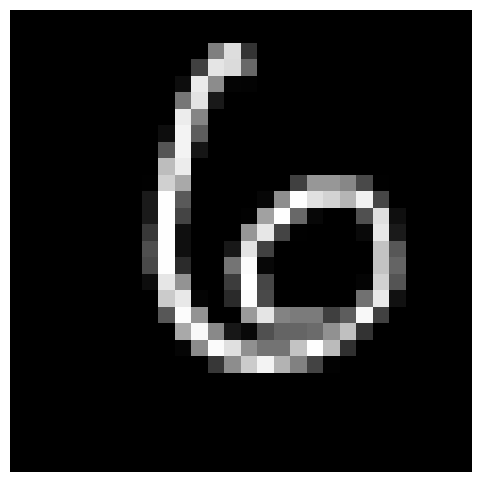

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Output: 10 squares


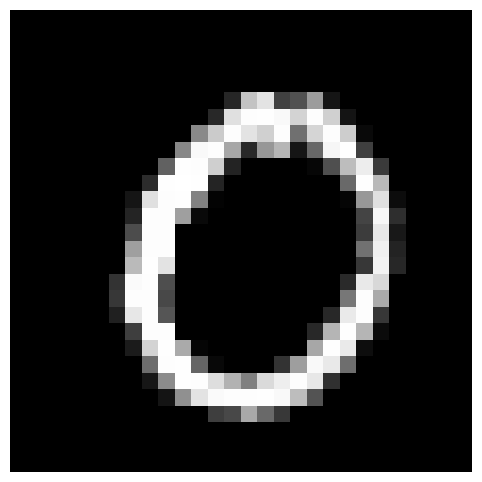

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Output: 10 squares


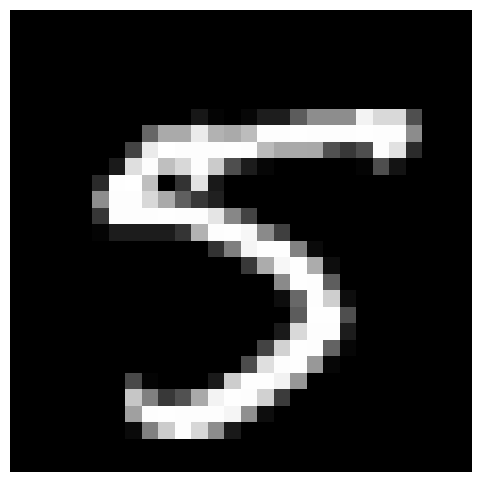

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Output: 10 squares


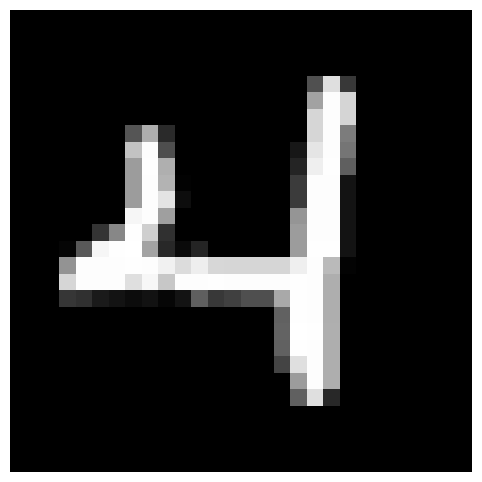

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Output: 10 Shapes: 5 Horizontal Lines, 4 Vertical Lines, 1 Checkerboard Pattern


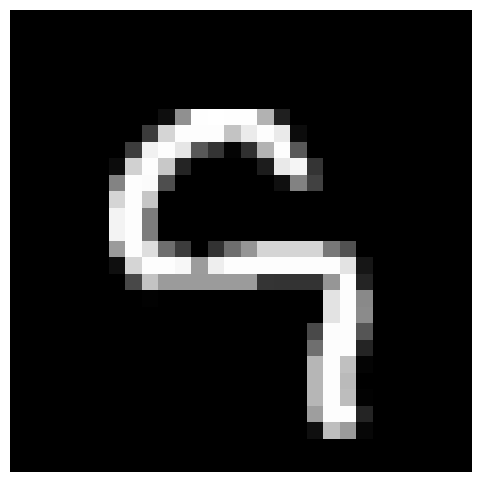

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Output: 10


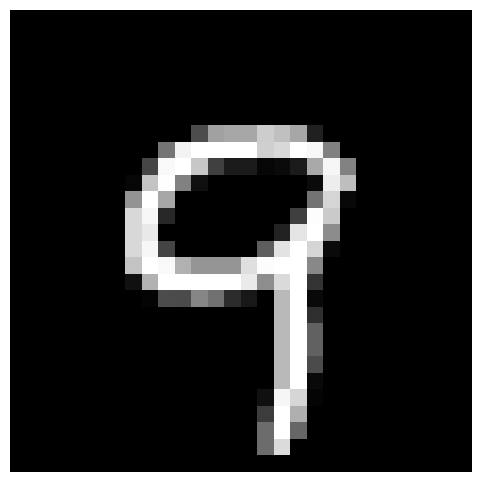

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Output: 10 squares


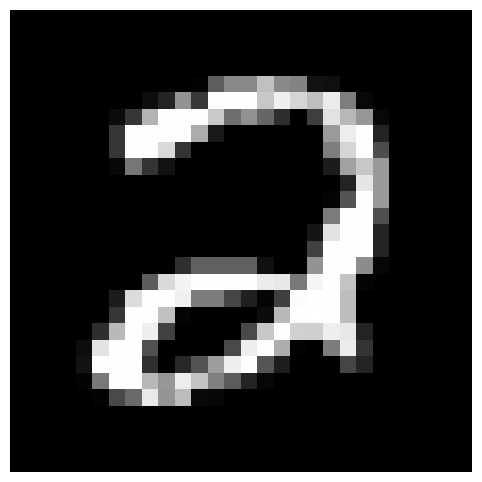

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Output: 10 Images with 25 Shapes


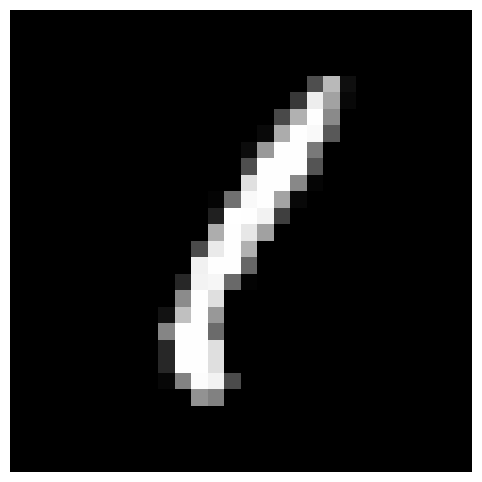

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Output: 10 squares


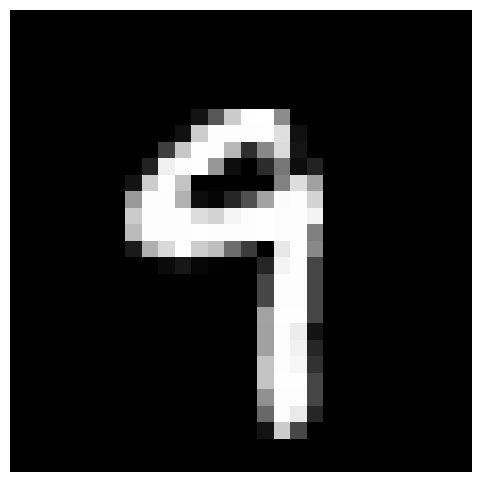

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Output: 10 Shapes: 5 Horizontal Lines, 4 Vertical Lines, 1 Checkerboard Pattern


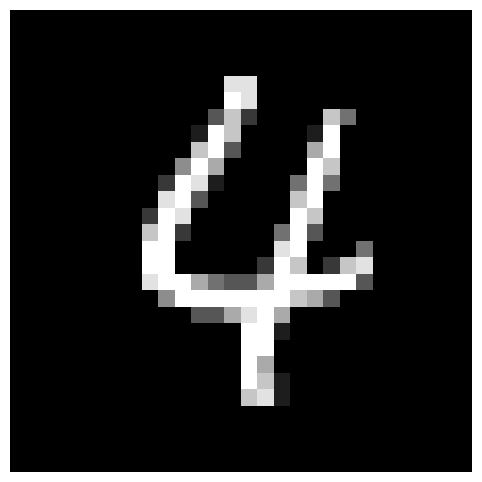

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Output: 10 squares


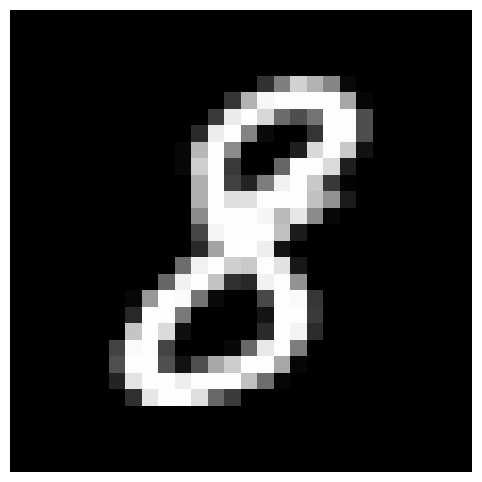

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Output: 10 squares


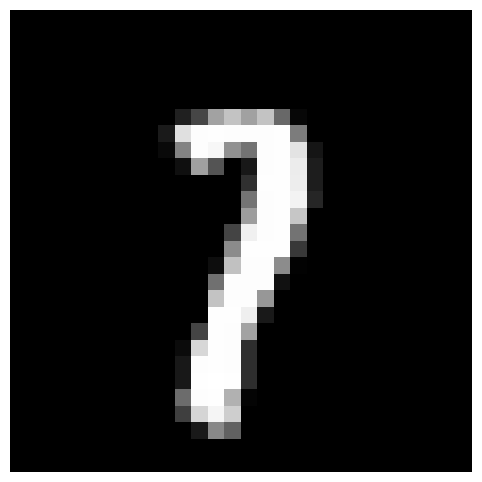

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Output: 10 squares


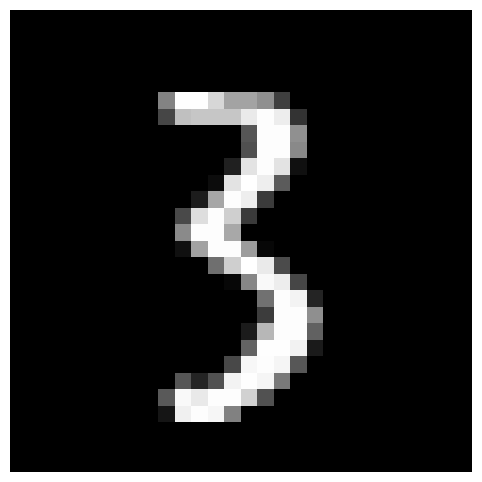

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Output: 10 squares


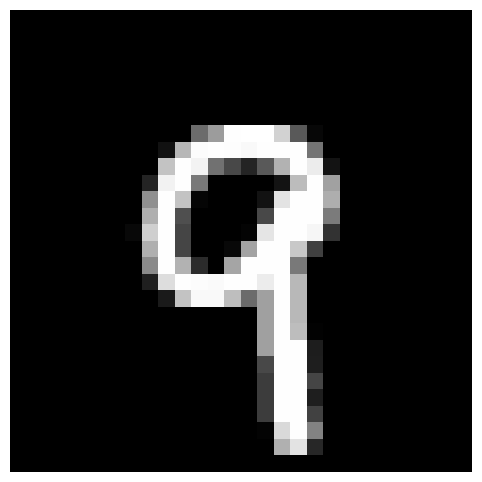

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Output: 10 squares


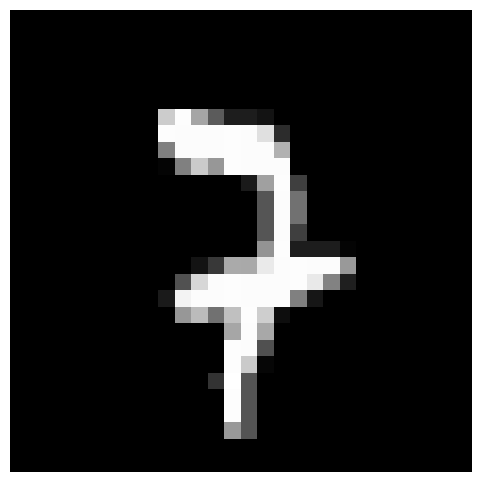

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Output: 10 squares


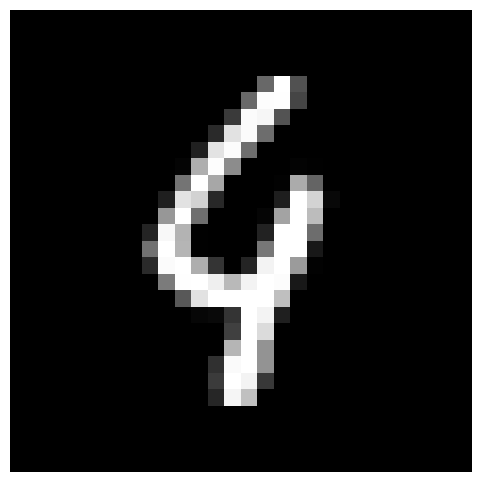

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Output: 10 squares


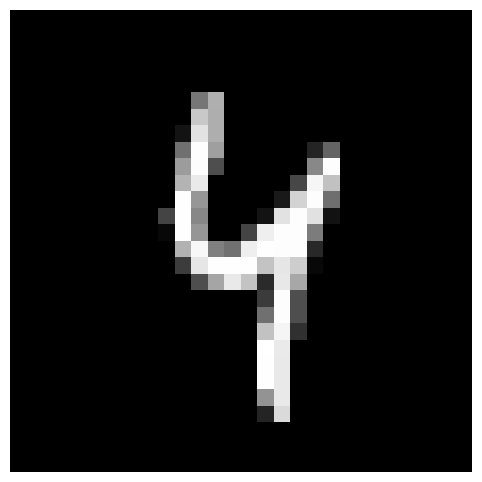

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Output: 10 squares


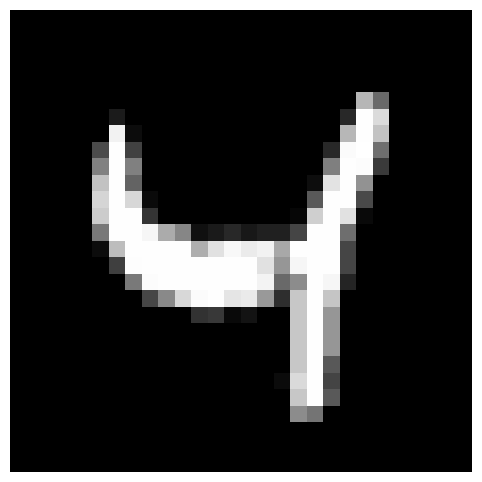

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Output: 10 Shapes: 5 Horizontal Lines, 4 Vertical Lines, 1 Checkerboard Pattern


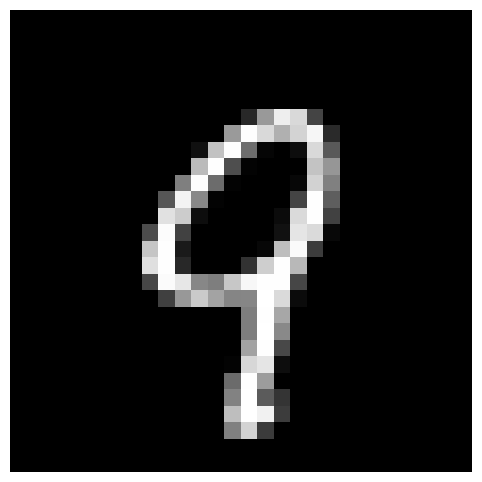

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Output: 10 squares


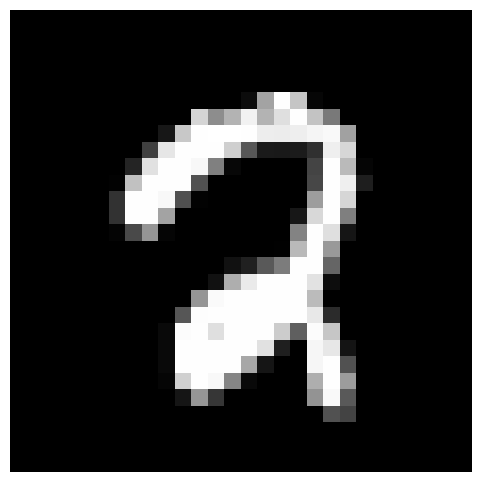

### Output: 10 shapes: 3 circles, 2 squares, 5 triangles


In [15]:
for i, image in enumerate(test_images):
    if i >= 20:
        break
        
    jsonl_data = generate_jsonl_data(targetCNN, [image])
    specific_entry = jsonl_data[0]  # Get the entry for the current image
    prompt = f"""You will be presented with sequences of characters representing features of images, which could be basic geometric structures or elements similar to MNIST handwritten digits. These sequences are encoded representations of the image's activation maps, derived from the first layer of a convolutional neural network. The character 'f' marks the beginning of a new filter's activation map of the first layer. The characters 'z', 'l', 'm', 'h', and 'v', indicate varying levels of activation: zero, low, medium, high, and very high, respectively. Your task is to understand the patterns in the sequence and to interpret these sequences to determine the number and types of shapes present in the image. The desired output format should be 'output: Image with [number of shapes] shapes: [number of first shape] [name of shape] ... [number of last shape] [name of last shape]', where the description includes the types of shapes, such as corners, edges, ellipses, crossings, checkerboard pattern, horizontals, verticals, etc. ### Input: """
    outputPrompt = "### Output: "

    modified_input = prompt + specific_entry['input'] + outputPrompt 
    model_input = tokenizer(modified_input, return_tensors="pt").to("cuda")
    
    with torch.no_grad():
        generated_output = tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=60, repetition_penalty=1.15)[0], skip_special_tokens=True)
    start_idx = generated_output.find("### Output:")
    if start_idx != -1:
        output_tokens = generated_output[start_idx:].split()[:200] 
        shortened_output = ' '.join(output_tokens)
    else:
        shortened_output = "Output not found."
        print(generated_output)
    plt.figure(figsize=(10, 6))  
    plt.imshow(image.squeeze(), cmap='gray')  
    plt.axis('off')  
    plt.show()
    print(shortened_output)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


fzzzlzzmllzzzzzzzzlzmmzzzzzzzzzlzlmzllzzzzzzzllllmmzzzzlzzzzzlllzlmllllzzllzzzmmlzzllzzllzzmmlzzlllzzzmzlmlllllllzzlllmllzmhlzlzzllllmmmhmlllzzllllllllzllzzzzlllllllllzzzzzzlllllzzzzzzzzzzzzzzzzzzzfzzzllzzzllzzzzzzzlllmmmlzzzzzzllllllzzzzzzzzllzllllllzzzzzllllllzzzzzzzzlllllmmhhmllzzlllllllmlzzlzzlllllzllzzllzzllmmlmzzlmmlzzlllmmhhhmmlzzzzlllhhhmmllzzzzllzzzzzzllzzzzzlllzzzzzzzzzzzzzzzzzzzzzfllllmmmmmlllllllllmlmhlllllllllmmllmzllllllllmlllllmmmllllmmzlmmhmmmllllmmllmlmhmmmlllmllmmlmmzzlllllllmmmmmlllllllllmmhhhlmlzllllzmzmmlllzzllllzzzzzzzzzllllllzzzzzzzzllllllllllzzlllllllllllllllllfzzzzlzzlzzzzzzzzzllzllzzzzzzzzzlmzlzlzzzzzzzlllllzlzzllzzzllzlllzlzzllzzllzlllmllzzlzzllzzmllmzlmzzzllzlllzlllmzzzllllllllzzllzzlmzmmzmmzzllzzzmmzhhlllzllzzzzllzllllllzzzzzzzzzllllzzzzzzzzzzzzzzzzfzzzzzlhhzzzzzzzzzzzhhlzzzzzzzzzzzhvzzzzzzzzzzzlvmzzmmmlzzzzzmvlzhhmlzzzzzzhvzhhllmlzzzzzhhzhhzlhmzzzzzhhzhmzmvhzzzzzmhzhmlmhzzzzlzlmllmllzzzzzllzllllzzzzzzzzllzmlzlllzzzzzzlllllllzzzzzzzzzzzzzzzzzfzzzllzzzzzzzzz

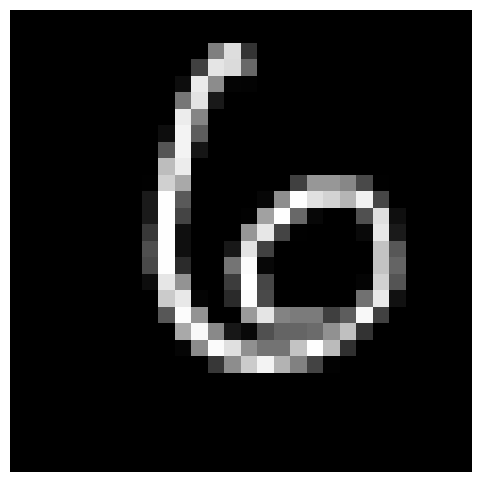

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Output: 10 shapes: 3 circles, 2 squares, 5 triangles
fzzzzzlzzzzzzzzzzzlllzzlzllzzzzllzzmmmllllzzzlzzhhmllzzlzzzlzhhlzllllllzlzlmzllllzllzzlzllllllzzzllzzllzllllzzlllzlllzzllzlmllzzllzmlzzmmmlllzllllllhhhzlzlzzllllmmmzllzzzzlllzlzlllzzzzzzzllzlllzzzzfzzzzzllllzzzzzzzzzllzzzzzzzzzzzllzzlmmzlzzzzllzlmvvvmllzzzlzllmhmmmllzzlllmlmllzllllzllllllzllzlzlzlllllzzllzzllzlmmllzllzllmzzlllmzlzzzlmlzzzllmhlhhmmmzzzzllmhvvvhmzzzzzzllzzzlzzzzzzzzzlzzzzzlzzzflllllllllllllllllllmhhhhhmllllllmhhhhhhmlllllmhhmhhmmmllllmhhlmlzzzllmllmmlmlzzzzzllllmlllzzlmllllllmlllzlmmllmzllmzlllmhmlmlzllllllhvvmmmzzlllzllhhmlmzzllllzzzzlllzzzlllllzzzzzzzzlllllllllzzzzlllfzzzzzzzzzlllzzzzzzzzzzzzlllzzzzzzzzllzzllzzzzzzlmmmlzzllzzllzlmlmllmzlzzllzlllmmzmmlzlmlzllllmzlmlzlmzzlmlzlzlllzlmzzzmlzlzlllzlmzzlzlllllllzzmmzmmllzlzllzzlmllhhlzzllzzzzmmlmllllllzzzzzzlzlllllzzfzzzzzzzllllzzzzzzzzzlhhmmzzzzzzzzzhhhmmzzzzzzzzvhmzlmlzzzzzzhvhzzlhhzzzzzzvvzzzzhhlzzzzlvvzzzzmvmzzzzmvhzzzzhvlzzzzmvhzzzlvvzzzlzlvhzzmhvlzzzlzzhhzlmmmzzz

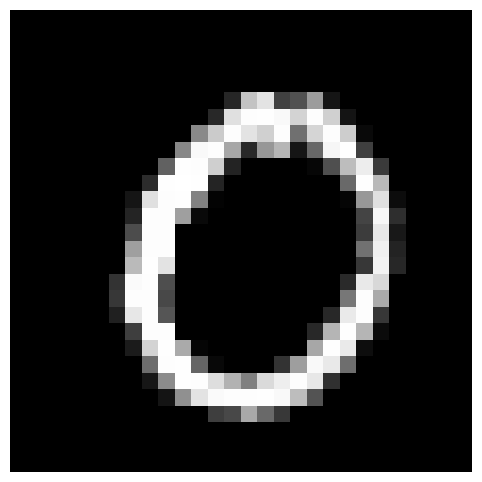

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Output: 10 shapes: 3 circles, 2 squares, 5 triangles
fzzzzzzzzzzzzzzzzllzzllzzzzllzllzzzlmmmmmmlllzzmmmmmllllzzzlhmlzzzzlzllzlmmllmmlllzlllllzmlllzlllzzlzlzlllllzllzzzzlllllzzmmlzzzllzllzlhmllzzzzllzzhvhzzlzzzzzllhhmzlllzzzllllmzllllzzzzlllzzlllzzzzzfzzzzzzzzzzzzzzzzzlllllllllzzzlllzzzzzzzzllzllzlhvvvvvvhmlzllmvvhhmmlllllmhvhmzzzzzzzllmmhhhhmzzzllzzzzzzlhhlzzzzzllzlllzzzzllzzzlllllzzlmllzzlzzzzzmhhmlzzzllmhvvhhmzzzzzllmvvvmlzzzzzzzllzzzzzzzzzzflllllllllllllllllllmmmmmhhmmlllhhhvhhvhhmmllhhhhhmmmmmmmlmhmhvhmlzzzzzlmlllzzlmmlzzzllzlzzlmmmmllllllzzzzzlmmmllllllllzlzlmmlllllllmhhzmlllllllmhvvhmmzzlllllmmmlmmzzzlllllllzlzzzzllllllzzzzzzzllllfzzzzzzzzzzzzzzzzzzzzzzzzzzllzzzzzzzzzzzzzlzzzzzllllllllzzlmmllhmmmlzllzmmmmzzzzmmllllmlllmlmzzllzlzzlllmlmlzzlzzzzzzzlmlzmhzzzzzzzzzzlllhlzzzllzzzlmlzllzzzzlllmllzzllzzzlmmmmzzllllzzzzlmzzllllzzzzfzzzzzzzzzzzzzzzzzzzlllllmhhlzzzzmhmmmmmhmzzzzlhhmlzzlmlzzzzmvhmlzzzmlzzzzmmzllmmzllzlzzmmzllmmlzlzzlzzzzzzmhmzzzzzllllzzvvhzzzzzzzllzmvvlzzzzzzzllhhhmzzzz

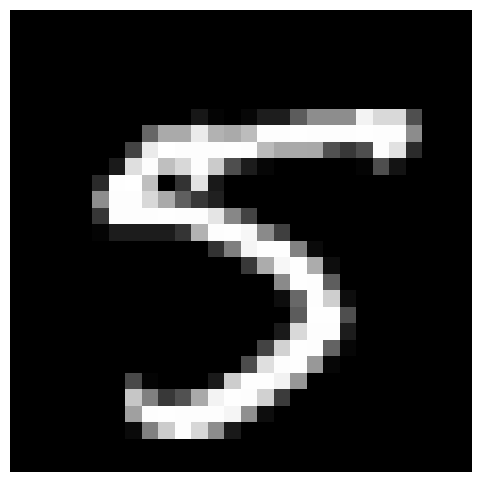

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Output: 10 shapes: 3 circles, 2 squares, 5 triangles
fzzzzzzzllzzlzzzllzzzzlzllllzzllzzllzzllllzzzzzlllllzllzzzlzzlllllzlllzllzllllllzlllzlzhmlmmmmlllzzlmmlllmmllllzzmmzzlllzzlllzzzzzzlzzlllllzzlllzzzllzlllzzzzzzzzlllzzlzzzzzzzzllzlllzzzzzzzzzlllzzzzfzzzzzzzllllzzzzzlllzzlzzzzzzzllzzzzllllllzzzllzzzllllllzzlllllllllllzzlllzzllllzzzzzlzzzzzzzzzlzzzlhvvvvvvvmllzzmmhhhhhhhmlzzzzzzzzzzllllzzzllzzlzllmmmlzzzzzzzzlllmmlzzzzzzzzzlzzzzzzzzzzzzzllzllzzfllllllllllmllllllllllmmmlmllllmmlllmmmmmllllmmmmmmlmmmllllmmmmmmlllzlllmhlmhlhlllzllmhhhhhhvhmmlllmmllllmhmmmzlllzlzzzlmlllzllllzzzzzzzzzzllllllllllzzzzllllllllllzzzzllllllllllzzzzlllllllllllllzllfzzzzzzzzzzzllzzzzzzlllzzzllzzllzzllllzlllzzlzzzzlmmzllzzzllzlmlllzlmlzzllzlmlmzzlllzlllzzzzlzzmmzzlllzzlllzzmmzzmmmmmhmmzzlmzzlzzlllmmzlmlzzzzzzzzlmzlllzzzzzzzzlllzmlzzzzzzzzzlzzmlzzzzzzzzzzlzllzzfzzzzzzzzzlmlzzzzzzllzzzhvlzzzzzlhmzzzvvzzzzzzlvhzzzvvzzzzzzhvhzzzvvzzzzzzvvmzzmvvzzzzzmvvlllhvvzzzzzmmlzzzmvhzzzzzlmlzzzhvmzzzzzzzzzzzhvmzzzlllllzlzhvmzzz

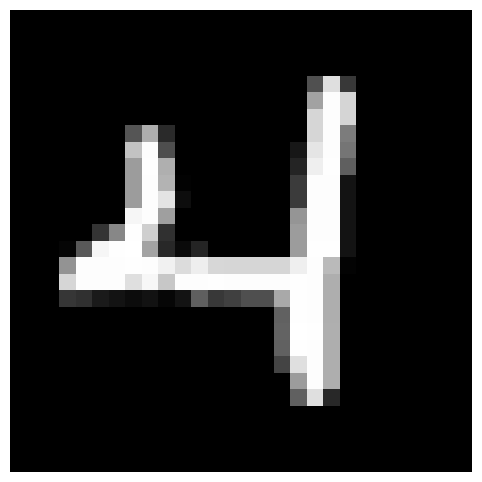

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Output: 10 shapes: 3 circles, 2 squares, 5 triangles
fzzzzzzzzzzzzzzzzlllzzzzlzzzzzllzzmmmlllzzzzlzlhmlllllzzzzlzmhzllllzzzzzlmlzllzzzllzzzllzllmmmllllzzllzlllllzzllzzllzlllzzlmllzzlzzzzlllllllzzzlllzzllzlllzzzzzzzzllllllzzzzzzzzllzzlzzzzzzzzzllzlllzfzzzzzzzzzzzzzzzzzllllzzzzzzzzzllzzllzzzzzzzlllmhvvhllzzzzllmlmmlmmllzzzlllllzzlzzzzzzllmlzzzllzzzzzllmhvvvvvmllzzlllmmmllzzllzzzllzzzllllllzzzllzlzlllllzzzzzzzzzlmhmllzzzzzzzzlmmmllzzzzzzzzllzzzzzflllllllllllllllllllmhhhmlllllllhhhhhmmllllllmhmhhmmmlllllmmmzmzzzllllllmmlmmllmmllllllllmhhhmmmllllllzzzmmhhhmmlllzzzzzzzzzmllllllllzmmzllzllllllllmmzllzllllllllmlzzzzlllllllllzzzzzlllllllllzzzzllfzzzzzzzzzzzzzzzzzzzzzllllzzzzzzzzzlzzllzzzzzzzlmmllzlzzzzllllmlzmmzzzzzmmzzzmlzmmllzzmmzlzzlzzzllzzmlzmhmmlzzzlzzlmmmhmllzmmzzzzzlzlllmzlmlzzzzzzzzlmzzllzzzzzzzzlmzlllzzzzzzzzlmzlmzzzzzzzzzllzzmlzfzzzzzzzzzzzzzzzzzzzlhhmlzzzzzzzzmhhmmlzzzzzzzlvhzlmlzzzzzzzhvmzlmlzzzzzzzvvzzlhhmlzzzzzhvzllmmmlzzzlzmhzzlzmhmzzzlzlmlzlzhvmzzzzlzzzlzzvvlzzzzzllllzzvvzzz

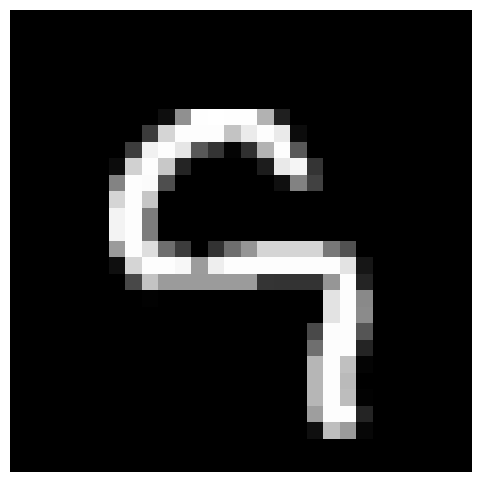

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Output: 10 shapes: 3 circles, 2 squares, 5 triangles
fzzzzzzzzzzzzzzzzzllzzzzzzzzzzzllzzlhmlllzzzllzlmmmmllllzzlzlmhllzlllzzzzlmmzzzlmmlzzzzmlzllhhllllzzlllllmhlzllzzzllllllzzllzzzzzllzzllllllzzzzzllllzlllzzzzzzzzzlllllzzzzzzzzzlmzzlzzzzzzzzllllllzzzfzzzzzzzzzzzzzzzzzzllllzzzzzzzzllllzzzzzzzzzzllzmhvvhlzzzzlllmhvvhhmllzzzlllllzzzlllzzllllzzzzlllzzzllmhvvvhmlzzzzlllmhhhmlzzzzzzllzzlzllllzzzzzlllllllllzzzzzzzllllllzzzzzzzzzlmmllzzzzzzzzlllllzzzzfllllllllllllllllllllllllllllllllmhhhhmmllllllmhhmmmmmmllllmmmmhmmmlmllllmlmmzmzzllllllmlmmhvlmmzllllllllmmmmlzlllllzzzmlzzzzllllllzzzzzzllllllllllmlzlllllllllllmlzlzlllllllllmzzzzllllllllllzzzzlllfzzzzzzzzzzzzzzzzzzzzzzzllzzzzzzzzzlzzlllzzzzzzzzllzzzllzzlzllmmlzzmzzzzlmlzzlmmzmlzzzlmzlzzlzllllzzllzzmmlzzllzzzlmmzhhlzlmlzzzzllzzmmzmmlzzzzzzzzllzlmzzzzzzzzzllzlllzzzzzzzzlllllzzzzzzzzllzzllzzzfzzzzzzzzzzzzzzzzzzzzlllllzzzzzzzzmhmmmlzzzzzzzmhhzlmmlzzzzzzvvzzzhvzzzzzzlvhzzhvvzzzzzzlvmzmhvlzzzzlzlhmzzhvzzzzzlzzmmzzvvzzzzzzlzzzzzvvzzzzzzzlllzzvvzzzz

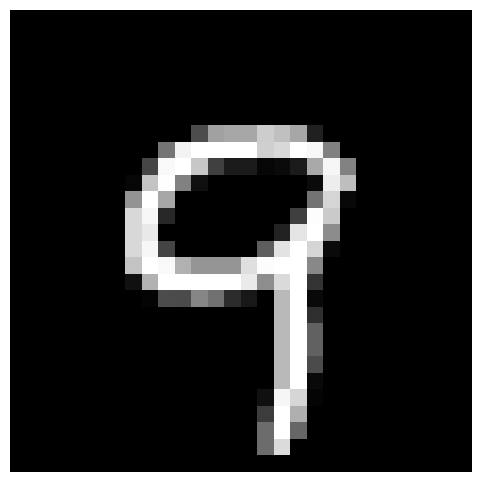

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Output: 10 shapes: 3 circles, 2 squares, 5 triangles
fzzzllzzzzzzzzzzllzzzmmmllllzzlzlmhmmlzzllzzzlmhmzzlllllzzlmlzllllzzllzzlzzllllzzlllzzlllzzmllmllllzllzmmmmllzllzllzhhmzzhlzllzzzmmzlhvhlllzzzmmllhhmzlllzzllllmmzlllzllzllzlzllllzlzzzzlllllzzzzzzzzfzzzlllllzzzzzzzzlllzzzlzzzzzzllzlhvvvhllzzzlmhhvhmlmmllzzlmmmlzzllllzlzlzzzzllzzzzllzzlllzzzzzlllzzllzzmhhhllllzllzmmvvhmmllzzllmlmlzmhhhllzllmhhhhmmmzllzlllhhhmmzzzzzzzzlzzzzzlzzlzzzzllzllzzzzzzzfllllllmmhmmllllllmhhhhhmmmllllmhhmhmmmmmmlllmllmlzzzlmmllllzzzzllzlzllllllzzzlmmlmllllllhhhhvhmmllllmhhhhhvmmmzllmhmhhhvhlmlzllhhlhhzzzzzzzllmlmmzlllzzzzlllzzzzzzzzzzzlllzzzzzzlzllzlllllllzlllllllfzzzzzzzzzlllzzzzzzzzzlzzzllzzllzzlmllzzzllzzmmmmlllzzlllzlmlzzllmlzmmzzllzzlllllzmmzzzzzzzzzllllllzzzzzzlllzllmllzzzmmllmlzlmzlmmzlzmmmllmlzlmmzlmmmmzmmlzlmllmmlzlllmlzzllzzlllllzzlzzzzzllllzzzzzzfzzzzzzlhmmllzzzzzzlhhhmlmmzzzzzzhhmzzlhmzzzzzlhmzzzlhhzzzzzlmlzlzzvvzzzlzzlllzzzvvzzzzlzlhmmzhvvzzzzzlhvmzzvvlzzzzzvvmzmmvhzzzzzzvvzlmllmzzzzzzhhzllzzmzzz

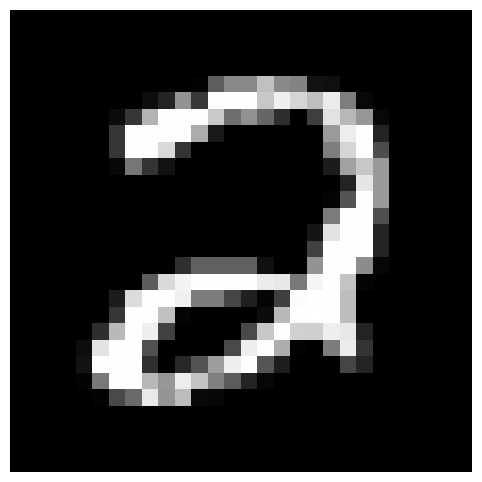

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Output: 10 shapes: 3 circles, 2 squares, 5 triangles
fzzzzzzllzzzlzzzzzzzzlzzlllzzzzzzzllzmmllzzzzzzllzmmlllzzzzzzlzzmllllzzzzzllzmmzllzzzzzzlzlmlllzzzzzzlllllzllzzzzzzzlllzllzzzzzzzzllllllzzzzzzzzlllllzzzzzzzzlllzzlzzzzzzzzzllzlllzzzzzzzzllllzzzzzzzfzzzzzzzllllzzzzzzzzzllzzzllzzzzzzllzzzllzzzzzzzlzlllmlzzzzzzlllllmlzzzzzzzllllmmzzzzzzzlllllmlzzzzzzzllllmlzzzzzzzlllzllzzzzzzzzllllllzzzzzzzzllmhmllzzzzzzzzllmmllzzzzzzzzllzzzzzzzzzzzzzllzlzzzzzzflllllllllllllllllllllmmmmmllllllllmhmmhmlllllllmhhlhmzlllllllmmmmmzzllllllmmmlllzzllllllmmlllzzllllllmmlllzzlllllllmmlllzzlllllllmmlllzllllllllllzzzllllllllllzzzzlllllllllllzzzllllllllllllllllllllfzzzzzzzzzzllzzzzzzzzzzzzllzzzzzzzzzzzlmzzzzzzzzzlzzlllzzzzzzzzlzllllzzzzzzzllzlzllzzzzzlllzlllllzzzzzzlzlllllzzzzzzlmzllllzzzzzzzmmzzlmlzzzzzzlmlzmlzzzzzzzzzmmzmmlzzzzzzzzllzzmlzzzzzzzzzzlzllzzzzzfzzzzzzzzzlmlzzzzzzzzzzlvhzzzzzzzzzzzvvmzzzzzzzzzzmvvzzzzzzzzzzzvvmzzzzzzzzzzhvvzzzzzzzzzzzvvzzzzzzzzzzzhvhzzzzzzzzzzzvvzzzzzzzzzzzzvvzzzzzzzzzlzzvvzzzzzzz

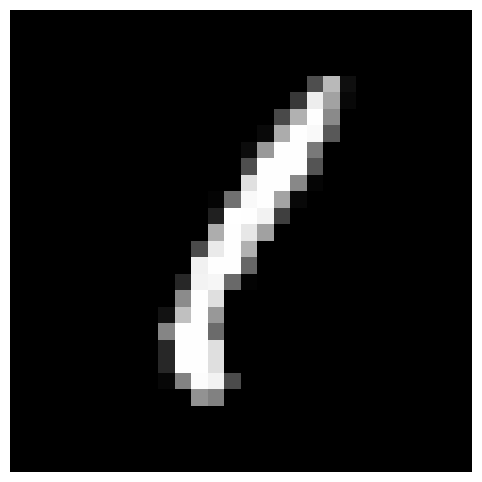

### Output: 10 shapes: 3 circles, 2 squares, 5 triangles


In [17]:

for i, image in enumerate(test_images):
    if i >= 8:
        break
        
    jsonl_data = generate_jsonl_data(targetCNN, [image])
    specific_entry = jsonl_data[0]  # Get the entry for the current image
    prompt = f"""You will be presented with sequences of characters representing features of images, which could be basic geometric structures or elements similar to MNIST handwritten digits. These sequences are encoded representations of the image's activation maps, derived from the first layer of a convolutional neural network. The character 'f' marks the beginning of a new filter's activation map of the first layer. The characters 'z', 'l', 'm', 'h', and 'v', indicate varying levels of activation: zero, low, medium, high, and very high, respectively. Your task is to understand the patterns in the sequence and to interpret these sequences to determine the number and types of shapes present in the image. The desired output format should be 'output: Image with [number of shapes] shapes: [number of first shape] [name of shape] ... [number of last shape] [name of last shape]', where the description includes the types of shapes, such as corners, edges, ellipses, crossings, checkerboard pattern, horizontals, verticals, etc. ### Input: """
    outputPrompt = " ###  Question: How many curves are in the image, 0, 1, 2, 3, 4, 5? Explain your answer first ###  Explanation of Answer: "

    modified_input =  specific_entry['input'] + outputPrompt 
    model_input = tokenizer(modified_input, return_tensors="pt").to("cuda")    
    
    with torch.no_grad():
        generated_output = tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=150, repetition_penalty=1.15)[0], skip_special_tokens=True)
    print(generated_output)
    plt.figure(figsize=(10, 6))  
    plt.imshow(image.squeeze(), cmap='gray')  
    plt.axis('off')  
    plt.show()


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


fzzzlzzmllzzzzzzzzlzmmzzzzzzzzzlzlmzllzzzzzzzllllmmzzzzlzzzzzlllzlmllllzzllzzzmmlzzllzzllzzmmlzzlllzzzmzlmlllllllzzlllmllzmhlzlzzllllmmmhmlllzzllllllllzllzzzzlllllllllzzzzzzlllllzzzzzzzzzzzzzzzzzzzfzzzllzzzllzzzzzzzlllmmmlzzzzzzllllllzzzzzzzzllzllllllzzzzzllllllzzzzzzzzlllllmmhhmllzzlllllllmlzzlzzlllllzllzzllzzllmmlmzzlmmlzzlllmmhhhmmlzzzzlllhhhmmllzzzzllzzzzzzllzzzzzlllzzzzzzzzzzzzzzzzzzzzzfllllmmmmmlllllllllmlmhlllllllllmmllmzllllllllmlllllmmmllllmmzlmmhmmmllllmmllmlmhmmmlllmllmmlmmzzlllllllmmmmmlllllllllmmhhhlmlzllllzmzmmlllzzllllzzzzzzzzzllllllzzzzzzzzllllllllllzzlllllllllllllllllfzzzzlzzlzzzzzzzzzllzllzzzzzzzzzlmzlzlzzzzzzzlllllzlzzllzzzllzlllzlzzllzzllzlllmllzzlzzllzzmllmzlmzzzllzlllzlllmzzzllllllllzzllzzlmzmmzmmzzllzzzmmzhhlllzllzzzzllzllllllzzzzzzzzzllllzzzzzzzzzzzzzzzzfzzzzzlhhzzzzzzzzzzzhhlzzzzzzzzzzzhvzzzzzzzzzzzlvmzzmmmlzzzzzmvlzhhmlzzzzzzhvzhhllmlzzzzzhhzhhzlhmzzzzzhhzhmzmvhzzzzzmhzhmlmhzzzzlzlmllmllzzzzzllzllllzzzzzzzzllzmlzlllzzzzzzlllllllzzzzzzzzzzzzzzzzzfzzzllzzzzzzzzz

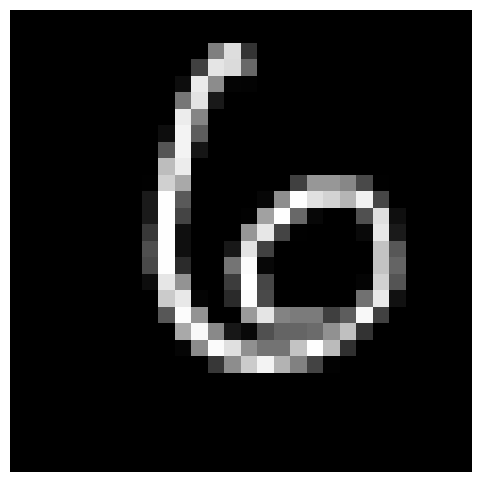

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


fzzzzzlzzzzzzzzzzzlllzzlzllzzzzllzzmmmllllzzzlzzhhmllzzlzzzlzhhlzllllllzlzlmzllllzllzzlzllllllzzzllzzllzllllzzlllzlllzzllzlmllzzllzmlzzmmmlllzllllllhhhzlzlzzllllmmmzllzzzzlllzlzlllzzzzzzzllzlllzzzzfzzzzzllllzzzzzzzzzllzzzzzzzzzzzllzzlmmzlzzzzllzlmvvvmllzzzlzllmhmmmllzzlllmlmllzllllzllllllzllzlzlzlllllzzllzzllzlmmllzllzllmzzlllmzlzzzlmlzzzllmhlhhmmmzzzzllmhvvvhmzzzzzzllzzzlzzzzzzzzzlzzzzzlzzzflllllllllllllllllllmhhhhhmllllllmhhhhhhmlllllmhhmhhmmmllllmhhlmlzzzllmllmmlmlzzzzzllllmlllzzlmllllllmlllzlmmllmzllmzlllmhmlmlzllllllhvvmmmzzlllzllhhmlmzzllllzzzzlllzzzlllllzzzzzzzzlllllllllzzzzlllfzzzzzzzzzlllzzzzzzzzzzzzlllzzzzzzzzllzzllzzzzzzlmmmlzzllzzllzlmlmllmzlzzllzlllmmzmmlzlmlzllllmzlmlzlmzzlmlzlzlllzlmzzzmlzlzlllzlmzzlzlllllllzzmmzmmllzlzllzzlmllhhlzzllzzzzmmlmllllllzzzzzzlzlllllzzfzzzzzzzllllzzzzzzzzzlhhmmzzzzzzzzzhhhmmzzzzzzzzvhmzlmlzzzzzzhvhzzlhhzzzzzzvvzzzzhhlzzzzlvvzzzzmvmzzzzmvhzzzzhvlzzzzmvhzzzlvvzzzlzlvhzzmhvlzzzlzzhhzlmmmzzzzzlzlmllzlzzzzzzzlzllzzzzzzzzzzlllzllllzzzfzzzzzlllzzzzzz

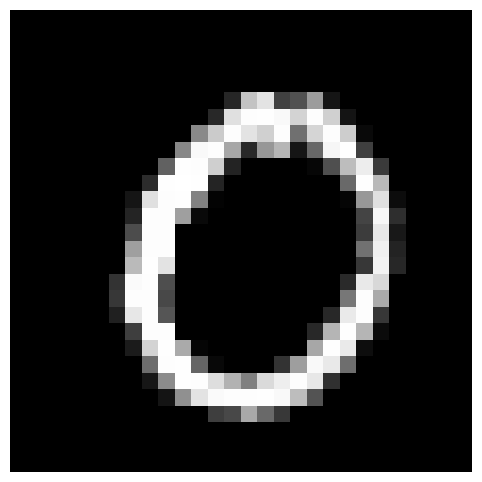

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


fzzzzzzzzzzzzzzzzllzzllzzzzllzllzzzlmmmmmmlllzzmmmmmllllzzzlhmlzzzzlzllzlmmllmmlllzlllllzmlllzlllzzlzlzlllllzllzzzzlllllzzmmlzzzllzllzlhmllzzzzllzzhvhzzlzzzzzllhhmzlllzzzllllmzllllzzzzlllzzlllzzzzzfzzzzzzzzzzzzzzzzzlllllllllzzzlllzzzzzzzzllzllzlhvvvvvvhmlzllmvvhhmmlllllmhvhmzzzzzzzllmmhhhhmzzzllzzzzzzlhhlzzzzzllzlllzzzzllzzzlllllzzlmllzzlzzzzzmhhmlzzzllmhvvhhmzzzzzllmvvvmlzzzzzzzllzzzzzzzzzzflllllllllllllllllllmmmmmhhmmlllhhhvhhvhhmmllhhhhhmmmmmmmlmhmhvhmlzzzzzlmlllzzlmmlzzzllzlzzlmmmmllllllzzzzzlmmmllllllllzlzlmmlllllllmhhzmlllllllmhvvhmmzzlllllmmmlmmzzzlllllllzlzzzzllllllzzzzzzzllllfzzzzzzzzzzzzzzzzzzzzzzzzzzllzzzzzzzzzzzzzlzzzzzllllllllzzlmmllhmmmlzllzmmmmzzzzmmllllmlllmlmzzllzlzzlllmlmlzzlzzzzzzzlmlzmhzzzzzzzzzzlllhlzzzllzzzlmlzllzzzzlllmllzzllzzzlmmmmzzllllzzzzlmzzllllzzzzfzzzzzzzzzzzzzzzzzzzlllllmhhlzzzzmhmmmmmhmzzzzlhhmlzzlmlzzzzmvhmlzzzmlzzzzmmzllmmzllzlzzmmzllmmlzlzzlzzzzzzmhmzzzzzllllzzvvhzzzzzzzllzmvvlzzzzzzzllhhhmzzzzzzzzmlmlzzzzzzzlzlmllzzzzzzzzlzzllzzlzzzzzfzzzzzzzzzzzzzz

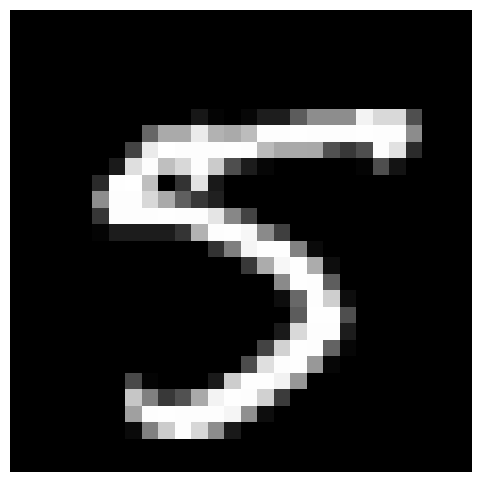

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


fzzzzzzzllzzlzzzllzzzzlzllllzzllzzllzzllllzzzzzlllllzllzzzlzzlllllzlllzllzllllllzlllzlzhmlmmmmlllzzlmmlllmmllllzzmmzzlllzzlllzzzzzzlzzlllllzzlllzzzllzlllzzzzzzzzlllzzlzzzzzzzzllzlllzzzzzzzzzlllzzzzfzzzzzzzllllzzzzzlllzzlzzzzzzzllzzzzllllllzzzllzzzllllllzzlllllllllllzzlllzzllllzzzzzlzzzzzzzzzlzzzlhvvvvvvvmllzzmmhhhhhhhmlzzzzzzzzzzllllzzzllzzlzllmmmlzzzzzzzzlllmmlzzzzzzzzzlzzzzzzzzzzzzzllzllzzfllllllllllmllllllllllmmmlmllllmmlllmmmmmllllmmmmmmlmmmllllmmmmmmlllzlllmhlmhlhlllzllmhhhhhhvhmmlllmmllllmhmmmzlllzlzzzlmlllzllllzzzzzzzzzzllllllllllzzzzllllllllllzzzzllllllllllzzzzlllllllllllllzllfzzzzzzzzzzzllzzzzzzlllzzzllzzllzzllllzlllzzlzzzzlmmzllzzzllzlmlllzlmlzzllzlmlmzzlllzlllzzzzlzzmmzzlllzzlllzzmmzzmmmmmhmmzzlmzzlzzlllmmzlmlzzzzzzzzlmzlllzzzzzzzzlllzmlzzzzzzzzzlzzmlzzzzzzzzzzlzllzzfzzzzzzzzzlmlzzzzzzllzzzhvlzzzzzlhmzzzvvzzzzzzlvhzzzvvzzzzzzhvhzzzvvzzzzzzvvmzzmvvzzzzzmvvlllhvvzzzzzmmlzzzmvhzzzzzlmlzzzhvmzzzzzzzzzzzhvmzzzlllllzlzhvmzzzzzzzzzlzlhlzzzzzzzzzlzlmlzzzzzzzzzzzlllzzzfzzzzzzzllzzzzz

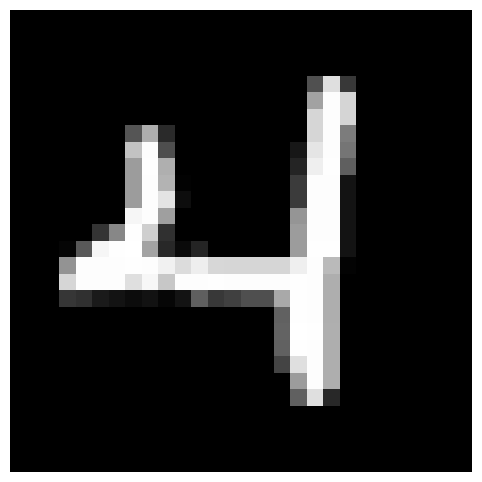

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


fzzzzzzzzzzzzzzzzlllzzzzlzzzzzllzzmmmlllzzzzlzlhmlllllzzzzlzmhzllllzzzzzlmlzllzzzllzzzllzllmmmllllzzllzlllllzzllzzllzlllzzlmllzzlzzzzlllllllzzzlllzzllzlllzzzzzzzzllllllzzzzzzzzllzzlzzzzzzzzzllzlllzfzzzzzzzzzzzzzzzzzllllzzzzzzzzzllzzllzzzzzzzlllmhvvhllzzzzllmlmmlmmllzzzlllllzzlzzzzzzllmlzzzllzzzzzllmhvvvvvmllzzlllmmmllzzllzzzllzzzllllllzzzllzlzlllllzzzzzzzzzlmhmllzzzzzzzzlmmmllzzzzzzzzllzzzzzflllllllllllllllllllmhhhmlllllllhhhhhmmllllllmhmhhmmmlllllmmmzmzzzllllllmmlmmllmmllllllllmhhhmmmllllllzzzmmhhhmmlllzzzzzzzzzmllllllllzmmzllzllllllllmmzllzllllllllmlzzzzlllllllllzzzzzlllllllllzzzzllfzzzzzzzzzzzzzzzzzzzzzllllzzzzzzzzzlzzllzzzzzzzlmmllzlzzzzllllmlzmmzzzzzmmzzzmlzmmllzzmmzlzzlzzzllzzmlzmhmmlzzzlzzlmmmhmllzmmzzzzzlzlllmzlmlzzzzzzzzlmzzllzzzzzzzzlmzlllzzzzzzzzlmzlmzzzzzzzzzllzzmlzfzzzzzzzzzzzzzzzzzzzlhhmlzzzzzzzzmhhmmlzzzzzzzlvhzlmlzzzzzzzhvmzlmlzzzzzzzvvzzlhhmlzzzzzhvzllmmmlzzzlzmhzzlzmhmzzzlzlmlzlzhvmzzzzlzzzlzzvvlzzzzzllllzzvvzzzzzzzzzzzzvvzzzzzzzzzzlzmhzzzzzzzzzzlzlmzzzfzzzzzzzzzzzzzz

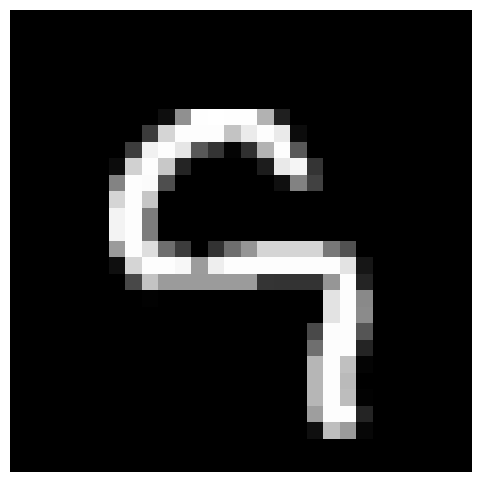

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


fzzzzzzzzzzzzzzzzzllzzzzzzzzzzzllzzlhmlllzzzllzlmmmmllllzzlzlmhllzlllzzzzlmmzzzlmmlzzzzmlzllhhllllzzlllllmhlzllzzzllllllzzllzzzzzllzzllllllzzzzzllllzlllzzzzzzzzzlllllzzzzzzzzzlmzzlzzzzzzzzllllllzzzfzzzzzzzzzzzzzzzzzzllllzzzzzzzzllllzzzzzzzzzzllzmhvvhlzzzzlllmhvvhhmllzzzlllllzzzlllzzllllzzzzlllzzzllmhvvvhmlzzzzlllmhhhmlzzzzzzllzzlzllllzzzzzlllllllllzzzzzzzllllllzzzzzzzzzlmmllzzzzzzzzlllllzzzzfllllllllllllllllllllllllllllllllmhhhhmmllllllmhhmmmmmmllllmmmmhmmmlmllllmlmmzmzzllllllmlmmhvlmmzllllllllmmmmlzlllllzzzmlzzzzllllllzzzzzzllllllllllmlzlllllllllllmlzlzlllllllllmzzzzllllllllllzzzzlllfzzzzzzzzzzzzzzzzzzzzzzzllzzzzzzzzzlzzlllzzzzzzzzllzzzllzzlzllmmlzzmzzzzlmlzzlmmzmlzzzlmzlzzlzllllzzllzzmmlzzllzzzlmmzhhlzlmlzzzzllzzmmzmmlzzzzzzzzllzlmzzzzzzzzzllzlllzzzzzzzzlllllzzzzzzzzllzzllzzzfzzzzzzzzzzzzzzzzzzzzlllllzzzzzzzzmhmmmlzzzzzzzmhhzlmmlzzzzzzvvzzzhvzzzzzzlvhzzhvvzzzzzzlvmzmhvlzzzzlzlhmzzhvzzzzzlzzmmzzvvzzzzzzlzzzzzvvzzzzzzzlllzzvvzzzzzzzzzzzzvvzzzzzzzzzzzlhmzzzzzzzzzlzlmlzzzzfzzzzzzzzzzzzzz

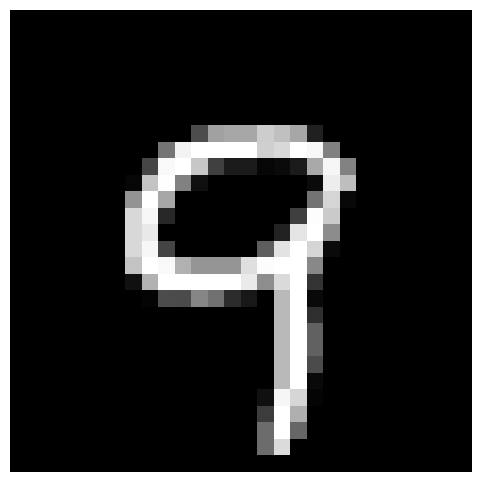

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


fzzzllzzzzzzzzzzllzzzmmmllllzzlzlmhmmlzzllzzzlmhmzzlllllzzlmlzllllzzllzzlzzllllzzlllzzlllzzmllmllllzllzmmmmllzllzllzhhmzzhlzllzzzmmzlhvhlllzzzmmllhhmzlllzzllllmmzlllzllzllzlzllllzlzzzzlllllzzzzzzzzfzzzlllllzzzzzzzzlllzzzlzzzzzzllzlhvvvhllzzzlmhhvhmlmmllzzlmmmlzzllllzlzlzzzzllzzzzllzzlllzzzzzlllzzllzzmhhhllllzllzmmvvhmmllzzllmlmlzmhhhllzllmhhhhmmmzllzlllhhhmmzzzzzzzzlzzzzzlzzlzzzzllzllzzzzzzzfllllllmmhmmllllllmhhhhhmmmllllmhhmhmmmmmmlllmllmlzzzlmmllllzzzzllzlzllllllzzzlmmlmllllllhhhhvhmmllllmhhhhhvmmmzllmhmhhhvhlmlzllhhlhhzzzzzzzllmlmmzlllzzzzlllzzzzzzzzzzzlllzzzzzzlzllzlllllllzlllllllfzzzzzzzzzlllzzzzzzzzzlzzzllzzllzzlmllzzzllzzmmmmlllzzlllzlmlzzllmlzmmzzllzzlllllzmmzzzzzzzzzllllllzzzzzzlllzllmllzzzmmllmlzlmzlmmzlzmmmllmlzlmmzlmmmmzmmlzlmllmmlzlllmlzzllzzlllllzzlzzzzzllllzzzzzzfzzzzzzlhmmllzzzzzzlhhhmlmmzzzzzzhhmzzlhmzzzzzlhmzzzlhhzzzzzlmlzlzzvvzzzlzzlllzzzvvzzzzlzlhmmzhvvzzzzzlhvmzzvvlzzzzzvvmzmmvhzzzzzzvvzlmllmzzzzzzhhzllzzmzzzlzzmmzzlzzllzzlzzllzzlllllzzzllllllzzzzzzzfzzzllllzzzzzzz

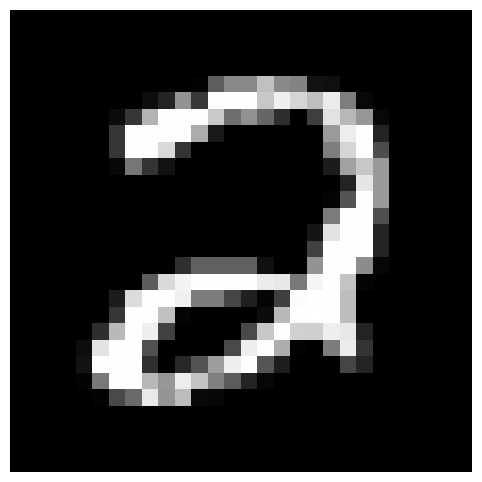

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


fzzzzzzllzzzlzzzzzzzzlzzlllzzzzzzzllzmmllzzzzzzllzmmlllzzzzzzlzzmllllzzzzzllzmmzllzzzzzzlzlmlllzzzzzzlllllzllzzzzzzzlllzllzzzzzzzzllllllzzzzzzzzlllllzzzzzzzzlllzzlzzzzzzzzzllzlllzzzzzzzzllllzzzzzzzfzzzzzzzllllzzzzzzzzzllzzzllzzzzzzllzzzllzzzzzzzlzlllmlzzzzzzlllllmlzzzzzzzllllmmzzzzzzzlllllmlzzzzzzzllllmlzzzzzzzlllzllzzzzzzzzllllllzzzzzzzzllmhmllzzzzzzzzllmmllzzzzzzzzllzzzzzzzzzzzzzllzlzzzzzzflllllllllllllllllllllmmmmmllllllllmhmmhmlllllllmhhlhmzlllllllmmmmmzzllllllmmmlllzzllllllmmlllzzllllllmmlllzzlllllllmmlllzzlllllllmmlllzllllllllllzzzllllllllllzzzzlllllllllllzzzllllllllllllllllllllfzzzzzzzzzzllzzzzzzzzzzzzllzzzzzzzzzzzlmzzzzzzzzzlzzlllzzzzzzzzlzllllzzzzzzzllzlzllzzzzzlllzlllllzzzzzzlzlllllzzzzzzlmzllllzzzzzzzmmzzlmlzzzzzzlmlzmlzzzzzzzzzmmzmmlzzzzzzzzllzzmlzzzzzzzzzzlzllzzzzzfzzzzzzzzzlmlzzzzzzzzzzlvhzzzzzzzzzzzvvmzzzzzzzzzzmvvzzzzzzzzzzzvvmzzzzzzzzzzhvvzzzzzzzzzzzvvzzzzzzzzzzzhvhzzzzzzzzzzzvvzzzzzzzzzzzzvvzzzzzzzzzlzzvvzzzzzzzzzzlzhhzzzzzzzzzzlzlmzzzzzzzzzzzllllzzzzzzfzzzzzzzllzzzzz

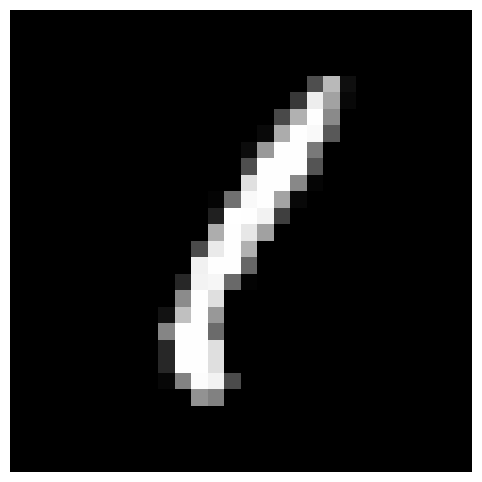

In [18]:

for i, image in enumerate(test_images):
    if i >= 8:
        break
        
    jsonl_data = generate_jsonl_data(targetCNN, [image])
    specific_entry = jsonl_data[0]  # Get the entry for the current image
    prompt = f"""You will be presented with sequences of characters representing features of images, which could be basic geometric structures or elements similar to MNIST handwritten digits. These sequences are encoded representations of the image's activation maps, derived from the first layer of a convolutional neural network. The character 'f' marks the beginning of a new filter's activation map of the first layer. The characters 'z', 'l', 'm', 'h', and 'v', indicate varying levels of activation: zero, low, medium, high, and very high, respectively. Your task is to understand the patterns in the sequence and to interpret these sequences to determine the number and types of shapes present in the image. The desired output format should be 'output: Image with [number of shapes] shapes: [number of first shape] [name of shape] ... [number of last shape] [name of last shape]', where the description includes the types of shapes, such as corners, edges, ellipses, crossings, checkerboard pattern, horizontals, verticals, etc. ### Input: """

    outputPrompt = "### Instruction: Write a comprehensive description of the number of shapes (horizontals, circles, contrasts, verticals, slanted lines etc.) ### Answer: "
 
    modified_input =  specific_entry['input'] + outputPrompt 
    model_input = tokenizer(modified_input, return_tensors="pt").to("cuda")
    
    with torch.no_grad():
        generated_output = tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True)
    print(generated_output)
    plt.figure(figsize=(10, 6))  
    plt.imshow(image.squeeze(), cmap='gray')  
    plt.axis('off')  
    plt.show()

In [19]:
inputString = "### Input: fzllzzmllzlzzlllmzzmmzlmllzzlmzzhhlzzzlzzlmzlhhzlzlllzzzllvhzlllmzlzzzlhvzllllllmzzzlhlllzlmzllzzzlmmlzzlmzllzzzllmzzzzhlhlzzzlllzzzlmzllzzzlllzzzlmzmlzzzlllzzzzlzlzzzzlzzzzzzzzzzzzzzllzzzzzzzzzzlmfzzzzzzzzmhvvvvzzzlllmlzzzzzzlllllmmzzzzzzlllllmmlzzzzzlllllmmlllllzzllmlmmzzlzlzzzllmmmzzzllzlzzllzzzzzzllzlzzllzzzzzzlmllzzllzzzzzllmmlzzllzzzzzzzzzzzzllzzzzzzzzzzzzllzzzzzzzzzzzzzzzzzzzzzzzzzzzzfzzzzzzzzzzzzzzzllmzmlzzzzzzzzlmmlmzmmmlzlzlmmllzzllmzzllmmllzmlllmzzlllzlzzmzzzzzzllzlzzzmzzzlzzllzzzzzmzzzlzzllzzzzzmzzzlzzllzzzzzlzzzlzzllzzzzzzzzzzzzllzzzzzzzzzzzzlllmhhhhhhhhhhvhmhvvvvvvvvvvvhfmmlmllmlllmllmllmzlmlhhhhhhhmmllllzzlmlmhhmlllmzmzzlzzllmmlmzmlzlzzzllmmmzlhlzllzzlllhzllmlzllzzllhlllzmlzllzzllmmlzzmlzllzzllmlzzzmmzllzzllmlzzzllzzmzzllmlzzzzzlzlzzllzzzzzzzzzzzzllzzzzzzzzzzzzzzflzzzlhmzzzzzzzmzzlvvzzzlllzzlzlhhzzzhmlzzzlzhmzzzmvlzzzzllmzzzzhvzzzzzhzzzzzzvvzzzzzhzzzzzzvvzzzzzhzzzzzzvvzzzzzlzzzzzzvvzzzzzlzzzzzzhmzzzzzlzzzzlzllzzzzzlzzzzzlzlzzzzzlzlllllllllllzlzmmmmmmmmmmmzfhvvvhvvvhhhhhhlmmlzllmhhvvvvmhllhhvllmllhmhmzhhhhlmmmmmmllhhhhhllmmmmmzhhhmhhmmhmmmmhvhmhmhmlhmmmmhhmhmmhmlhmmmmmmhmmmmhmhmmmmmmmmmmhvhhmmmmmmmmmmhvhhmmmmmmmmmmmhmhmmmmmhmmmmmmmmmmmlzzzzzzzzzzzzzzfzzzlzzzzzzzzzlzzzzzlzzzzzzzzlllzmllmzzzzzzllzlmlmvzzzzzzlzllzlzvzlzzzzzmlzlzzvzlzzzzmmzlzzzhzzzzzzlzlzzzzhzzzzzzzlzzzzzmllzzzzzzzzzzzzlzzzzzzzzzzzzzzzzzzzzzzzzzzzlzzzzzhhmmmmmmmmmmzzhhhhhhhhhhhhhlfmllmhmmmmzzlllmllllzlzzlmmmmlzzzzhlllmlllzmzzzvhzlzzzzzzmzzvvzzzmzzzzzmzvvzzzzhzzzzzzhvzzzzzmzzzzzhhzzzzzzmzzzzzhzzzzzzzmzzzzzlzzzzzzzhzzzzzlzzzzzzmhzzzzzlzzzzzzlzzzzzzmzzzzzzzzzzzzzmzzzzzzzzzzzzz"
prompt3 = "  ### Question: What does this input represent  ### Answer: "
modified_input = inputString + prompt3
model_input = tokenizer(modified_input, return_tensors="pt").to("cuda")

  
with torch.no_grad():
    generated_output = tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True)
print(generated_output)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Input: fzllzzmllzlzzlllmzzmmzlmllzzlmzzhhlzzzlzzlmzlhhzlzlllzzzllvhzlllmzlzzzlhvzllllllmzzzlhlllzlmzllzzzlmmlzzlmzllzzzllmzzzzhlhlzzzlllzzzlmzllzzzlllzzzlmzmlzzzlllzzzzlzlzzzzlzzzzzzzzzzzzzzllzzzzzzzzzzlmfzzzzzzzzmhvvvvzzzlllmlzzzzzzlllllmmzzzzzzlllllmmlzzzzzlllllmmlllllzzllmlmmzzlzlzzzllmmmzzzllzlzzllzzzzzzllzlzzllzzzzzzlmllzzllzzzzzllmmlzzllzzzzzzzzzzzzllzzzzzzzzzzzzllzzzzzzzzzzzzzzzzzzzzzzzzzzzzfzzzzzzzzzzzzzzzllmzmlzzzzzzzzlmmlmzmmmlzlzlmmllzzllmzzllmmllzmlllmzzlllzlzzmzzzzzzllzlzzzmzzzlzzllzzzzzmzzzlzzllzzzzzmzzzlzzllzzzzzlzzzlzzllzzzzzzzzzzzzllzzzzzzzzzzzzlllmhhhhhhhhhhvhmhvvvvvvvvvvvhfmmlmllmlllmllmllmzlmlhhhhhhhmmllllzzlmlmhhmlllmzmzzlzzllmmlmzmlzlzzzllmmmzlhlzllzzlllhzllmlzllzzllhlllzmlzllzzllmmlzzmlzllzzllmlzzzmmzllzzllmlzzzllzzmzzllmlzzzzzlzlzzllzzzzzzzzzzzzllzzzzzzzzzzzzzzflzzzlhmzzzzzzzmzzlvvzzzlllzzlzlhhzzzhmlzzzlzhmzzzmvlzzzzllmzzzzhvzzzzzhzzzzzzvvzzzzzhzzzzzzvvzzzzzhzzzzzzvvzzzzzlzzzzzzvvzzzzzlzzzzzzhmzzzzzlzzzzlzllzzzzzlzzzzzlzlzzzzzlzlllllllllllzlzmmmmmmmmmmmzfhvv

In [20]:
inputString = "### Input: fzllzzmllzlzzlllmzzmmzlmllzzlmzzhhlzzzlzzlmzlhhzlzlllzzzllvhzlllmzlzzzlhvzllllllmzzzlhlllzlmzllzzzlmmlzzlmzllzzzllmzzzzhlhlzzzlllzzzlmzllzzzlllzzzlmzmlzzzlllzzzzlzlzzzzlzzzzzzzzzzzzzzllzzzzzzzzzzlmfzzzzzzzzmhvvvvzzzlllmlzzzzzzlllllmmzzzzzzlllllmmlzzzzzlllllmmlllllzzllmlmmzzlzlzzzllmmmzzzllzlzzllzzzzzzllzlzzllzzzzzzlmllzzllzzzzzllmmlzzllzzzzzzzzzzzzllzzzzzzzzzzzzllzzzzzzzzzzzzzzzzzzzzzzzzzzzzfzzzzzzzzzzzzzzzllmzmlzzzzzzzzlmmlmzmmmlzlzlmmllzzllmzzllmmllzmlllmzzlllzlzzmzzzzzzllzlzzzmzzzlzzllzzzzzmzzzlzzllzzzzzmzzzlzzllzzzzzlzzzlzzllzzzzzzzzzzzzllzzzzzzzzzzzzlllmhhhhhhhhhhvhmhvvvvvvvvvvvhfmmlmllmlllmllmllmzlmlhhhhhhhmmllllzzlmlmhhmlllmzmzzlzzllmmlmzmlzlzzzllmmmzlhlzllzzlllhzllmlzllzzllhlllzmlzllzzllmmlzzmlzllzzllmlzzzmmzllzzllmlzzzllzzmzzllmlzzzzzlzlzzllzzzzzzzzzzzzllzzzzzzzzzzzzzzflzzzlhmzzzzzzzmzzlvvzzzlllzzlzlhhzzzhmlzzzlzhmzzzmvlzzzzllmzzzzhvzzzzzhzzzzzzvvzzzzzhzzzzzzvvzzzzzhzzzzzzvvzzzzzlzzzzzzvvzzzzzlzzzzzzhmzzzzzlzzzzlzllzzzzzlzzzzzlzlzzzzzlzlllllllllllzlzmmmmmmmmmmmzfhvvvhvvvhhhhhhlmmlzllmhhvvvvmhllhhvllmllhmhmzhhhhlmmmmmmllhhhhhllmmmmmzhhhmhhmmhmmmmhvhmhmhmlhmmmmhhmhmmhmlhmmmmmmhmmmmhmhmmmmmmmmmmhvhhmmmmmmmmmmhvhhmmmmmmmmmmmhmhmmmmmhmmmmmmmmmmmlzzzzzzzzzzzzzzfzzzlzzzzzzzzzlzzzzzlzzzzzzzzlllzmllmzzzzzzllzlmlmvzzzzzzlzllzlzvzlzzzzzmlzlzzvzlzzzzmmzlzzzhzzzzzzlzlzzzzhzzzzzzzlzzzzzmllzzzzzzzzzzzzlzzzzzzzzzzzzzzzzzzzzzzzzzzzlzzzzzhhmmmmmmmmmmzzhhhhhhhhhhhhhlfmllmhmmmmzzlllmllllzlzzlmmmmlzzzzhlllmlllzmzzzvhzlzzzzzzmzzvvzzzmzzzzzmzvvzzzzhzzzzzzhvzzzzzmzzzzzhhzzzzzzmzzzzzhzzzzzzzmzzzzzlzzzzzzzhzzzzzlzzzzzzmhzzzzzlzzzzzzlzzzzzzmzzzzzzzzzzzzzmzzzzzzzzzzzzz"
prompt3 = "### This input represents the char-encoded feature activations "
modified_input = inputString + prompt3
model_input = tokenizer(modified_input, return_tensors="pt").to("cuda")

  
with torch.no_grad():
    generated_output = tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True)
print(generated_output)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Input: fzllzzmllzlzzlllmzzmmzlmllzzlmzzhhlzzzlzzlmzlhhzlzlllzzzllvhzlllmzlzzzlhvzllllllmzzzlhlllzlmzllzzzlmmlzzlmzllzzzllmzzzzhlhlzzzlllzzzlmzllzzzlllzzzlmzmlzzzlllzzzzlzlzzzzlzzzzzzzzzzzzzzllzzzzzzzzzzlmfzzzzzzzzmhvvvvzzzlllmlzzzzzzlllllmmzzzzzzlllllmmlzzzzzlllllmmlllllzzllmlmmzzlzlzzzllmmmzzzllzlzzllzzzzzzllzlzzllzzzzzzlmllzzllzzzzzllmmlzzllzzzzzzzzzzzzllzzzzzzzzzzzzllzzzzzzzzzzzzzzzzzzzzzzzzzzzzfzzzzzzzzzzzzzzzllmzmlzzzzzzzzlmmlmzmmmlzlzlmmllzzllmzzllmmllzmlllmzzlllzlzzmzzzzzzllzlzzzmzzzlzzllzzzzzmzzzlzzllzzzzzmzzzlzzllzzzzzlzzzlzzllzzzzzzzzzzzzllzzzzzzzzzzzzlllmhhhhhhhhhhvhmhvvvvvvvvvvvhfmmlmllmlllmllmllmzlmlhhhhhhhmmllllzzlmlmhhmlllmzmzzlzzllmmlmzmlzlzzzllmmmzlhlzllzzlllhzllmlzllzzllhlllzmlzllzzllmmlzzmlzllzzllmlzzzmmzllzzllmlzzzllzzmzzllmlzzzzzlzlzzllzzzzzzzzzzzzllzzzzzzzzzzzzzzflzzzlhmzzzzzzzmzzlvvzzzlllzzlzlhhzzzhmlzzzlzhmzzzmvlzzzzllmzzzzhvzzzzzhzzzzzzvvzzzzzhzzzzzzvvzzzzzhzzzzzzvvzzzzzlzzzzzzvvzzzzzlzzzzzzhmzzzzzlzzzzlzllzzzzzlzzzzzlzlzzzzzlzlllllllllllzlzmmmmmmmmmmmzfhvv

In [21]:
inputString = "### Input: fzllzzmllzlzzlllmzzmmzlmllzzlmzzhhlzzzlzzlmzlhhzlzlllzzzllvhzlllmzlzzzlhvzllllllmzzzlhlllzlmzllzzzlmmlzzlmzllzzzllmzzzzhlhlzzzlllzzzlmzllzzzlllzzzlmzmlzzzlllzzzzlzlzzzzlzzzzzzzzzzzzzzllzzzzzzzzzzlmfzzzzzzzzmhvvvvzzzlllmlzzzzzzlllllmmzzzzzzlllllmmlzzzzzlllllmmlllllzzllmlmmzzlzlzzzllmmmzzzllzlzzllzzzzzzllzlzzllzzzzzzlmllzzllzzzzzllmmlzzllzzzzzzzzzzzzllzzzzzzzzzzzzllzzzzzzzzzzzzzzzzzzzzzzzzzzzzfzzzzzzzzzzzzzzzllmzmlzzzzzzzzlmmlmzmmmlzlzlmmllzzllmzzllmmllzmlllmzzlllzlzzmzzzzzzllzlzzzmzzzlzzllzzzzzmzzzlzzllzzzzzmzzzlzzllzzzzzlzzzlzzllzzzzzzzzzzzzllzzzzzzzzzzzzlllmhhhhhhhhhhvhmhvvvvvvvvvvvhfmmlmllmlllmllmllmzlmlhhhhhhhmmllllzzlmlmhhmlllmzmzzlzzllmmlmzmlzlzzzllmmmzlhlzllzzlllhzllmlzllzzllhlllzmlzllzzllmmlzzmlzllzzllmlzzzmmzllzzllmlzzzllzzmzzllmlzzzzzlzlzzllzzzzzzzzzzzzllzzzzzzzzzzzzzzflzzzlhmzzzzzzzmzzlvvzzzlllzzlzlhhzzzhmlzzzlzhmzzzmvlzzzzllmzzzzhvzzzzzhzzzzzzvvzzzzzhzzzzzzvvzzzzzhzzzzzzvvzzzzzlzzzzzzvvzzzzzlzzzzzzhmzzzzzlzzzzlzllzzzzzlzzzzzlzlzzzzzlzlllllllllllzlzmmmmmmmmmmmzfhvvvhvvvhhhhhhlmmlzllmhhvvvvmhllhhvllmllhmhmzhhhhlmmmmmmllhhhhhllmmmmmzhhhmhhmmhmmmmhvhmhmhmlhmmmmhhmhmmhmlhmmmmmmhmmmmhmhmmmmmmmmmmhvhhmmmmmmmmmmhvhhmmmmmmmmmmmhmhmmmmmhmmmmmmmmmmmlzzzzzzzzzzzzzzfzzzlzzzzzzzzzlzzzzzlzzzzzzzzlllzmllmzzzzzzllzlmlmvzzzzzzlzllzlzvzlzzzzzmlzlzzvzlzzzzmmzlzzzhzzzzzzlzlzzzzhzzzzzzzlzzzzzmllzzzzzzzzzzzzlzzzzzzzzzzzzzzzzzzzzzzzzzzzlzzzzzhhmmmmmmmmmmzzhhhhhhhhhhhhhlfmllmhmmmmzzlllmllllzlzzlmmmmlzzzzhlllmlllzmzzzvhzlzzzzzzmzzvvzzzmzzzzzmzvvzzzzhzzzzzzhvzzzzzmzzzzzhhzzzzzzmzzzzzhzzzzzzzmzzzzzlzzzzzzzhzzzzzlzzzzzzmhzzzzzlzzzzzzlzzzzzzmzzzzzzzzzzzzzmzzzzzzzzzzzzz"
prompt3 = "  ###  "
modified_input = inputString + prompt3
model_input = tokenizer(modified_input, return_tensors="pt").to("cuda")

  
with torch.no_grad():
    generated_output = tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True)
print(generated_output)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Input: fzllzzmllzlzzlllmzzmmzlmllzzlmzzhhlzzzlzzlmzlhhzlzlllzzzllvhzlllmzlzzzlhvzllllllmzzzlhlllzlmzllzzzlmmlzzlmzllzzzllmzzzzhlhlzzzlllzzzlmzllzzzlllzzzlmzmlzzzlllzzzzlzlzzzzlzzzzzzzzzzzzzzllzzzzzzzzzzlmfzzzzzzzzmhvvvvzzzlllmlzzzzzzlllllmmzzzzzzlllllmmlzzzzzlllllmmlllllzzllmlmmzzlzlzzzllmmmzzzllzlzzllzzzzzzllzlzzllzzzzzzlmllzzllzzzzzllmmlzzllzzzzzzzzzzzzllzzzzzzzzzzzzllzzzzzzzzzzzzzzzzzzzzzzzzzzzzfzzzzzzzzzzzzzzzllmzmlzzzzzzzzlmmlmzmmmlzlzlmmllzzllmzzllmmllzmlllmzzlllzlzzmzzzzzzllzlzzzmzzzlzzllzzzzzmzzzlzzllzzzzzmzzzlzzllzzzzzlzzzlzzllzzzzzzzzzzzzllzzzzzzzzzzzzlllmhhhhhhhhhhvhmhvvvvvvvvvvvhfmmlmllmlllmllmllmzlmlhhhhhhhmmllllzzlmlmhhmlllmzmzzlzzllmmlmzmlzlzzzllmmmzlhlzllzzlllhzllmlzllzzllhlllzmlzllzzllmmlzzmlzllzzllmlzzzmmzllzzllmlzzzllzzmzzllmlzzzzzlzlzzllzzzzzzzzzzzzllzzzzzzzzzzzzzzflzzzlhmzzzzzzzmzzlvvzzzlllzzlzlhhzzzhmlzzzlzhmzzzmvlzzzzllmzzzzhvzzzzzhzzzzzzvvzzzzzhzzzzzzvvzzzzzhzzzzzzvvzzzzzlzzzzzzvvzzzzzlzzzzzzhmzzzzzlzzzzlzllzzzzzlzzzzzlzlzzzzzlzlllllllllllzlzmmmmmmmmmmmzfhvv

In [22]:
inputString = "### Input: fzllzzmllzlzzlllmzzmmzlmllzzlmzzhhlzzzlzzlmzlhhzlzlll"
model_input = tokenizer(inputString, return_tensors="pt").to("cuda")
  
with torch.no_grad():
    generated_output = tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True)
print(generated_output)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Input: fzllzzmllzlzzlllmzzmmzlmllzzlmzzhhlzzzlzzlmzlhhzlzlllzm

Input is a series of 10-minute performances by artists, writers and musicians. The events are held at the ICA and other London venues, often in response to current exhibitions. Past contributors include Ed Atkins, Hannah Black, Jesse Darling, John Lawrence, Mary Manning, Raju Rage, Hito Steyerl, Nina Wakeford and Rehana Zaman.
The next event takes place on Thursday 28 June from 


In [23]:
inputString = "### Input: fzllzz"
model_input = tokenizer(inputString, return_tensors="pt").to("cuda")
  
with torch.no_grad():
    generated_output = tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True)
print(generated_output)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Input: fzllzz

### Output: 1024.000000

#include <stdio.h>
int main() {
    float a = 3;
    int b = (a + .5); // 3
    printf("%f\n",b+.5);// 3.500000
}
